Hi and welcome to our Statistics' Project Notebook! 
As you will discover along the way quite a few things changed from the milestone but the main objectives of the project remained the same.
Now let's kick things off with some classic imports

In [3]:
import os
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import chess.engine
from stockfish import Stockfish
import matplotlib.pyplot as plt
import math
from sklearn import mixture
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
import statsmodels.formula.api as smf

Now the first things we need are some utils functions to work with the data we collected so we first of all have to change the extensions of the .tcx files to .txt
The files in .tcx are the ones we will refer to as "activities" as they are called from the garmin app, which probably wasn't designed to track heartbeats when playing chess...

In [151]:
def change_ext(cartella, old_ext, new_ext):
    for root, dirs, files in os.walk(cartella):
        # print(os.getcwd())
        for f in files:
            filename = os.fsdecode(f)
            
                
            if filename.endswith(old_ext):
                name, ext = os.path.splitext(filename)
                
                new_name = name + new_ext
                jpath = os.path.join(root,new_name)
                os.rename(os.path.join(root,filename), jpath)
                print(f"renamed {os.path.join(root,filename)} to {jpath}")

change_ext("games", ".tcx", ".txt")

renamed games/partita_0814-2/white.tcx to games/partita_0814-2/white.txt
renamed games/partita_0814-2/black.tcx to games/partita_0814-2/black.txt
renamed games/partita_0814-2/zSanjatosti_vs_valesepicacchi_2022.08.14 (1).tcx to games/partita_0814-2/zSanjatosti_vs_valesepicacchi_2022.08.14 (1).txt
renamed games/partita_0816-6/w_activity_9418433002.tcx to games/partita_0816-6/w_activity_9418433002.txt
renamed games/partita_0816-6/roccot01_vs_tommidim_2022.08.16.tcx to games/partita_0816-6/roccot01_vs_tommidim_2022.08.16.txt
renamed games/partita_0816-6/b_activity_9418334461_tom.tcx to games/partita_0816-6/b_activity_9418334461_tom.txt
renamed games/partita_0816-1/w_activity_9416067935_tom.tcx to games/partita_0816-1/w_activity_9416067935_tom.txt
renamed games/partita_0816-1/b_activity_9418432154.tcx to games/partita_0816-1/b_activity_9418432154.txt
renamed games/partita_0816-1/tommidim_vs_roccot01_2022.08.16.tcx to games/partita_0816-1/tommidim_vs_roccot01_2022.08.16.txt
renamed games/par

Now we have to import the data from the [Portable Game Notation or pgn](https://en.wikipedia.org/wiki/Portable_Game_Notation)
and read the heartbeats of both white and black (in the games where they are both available) in order to create the dataframe for every game and then to visualize the data we are working with. 
The following cell has the code to get data from the **"activities" files**

In [4]:
### UTILS FOR READING THE ACTIVITIES

def calctime(start,curr):
    c = [int(x) for x in curr.split(":")]
    s = [int(x) for x in start.split(":")]
    return ((c[0] - s[0]) * 60 + (c[1] - s[1])) * 60 + (c[2] - s[2])

def read_activity(game):
    with open(game) as f:
        lines = f.readlines()
        hr = []
        time = []
        for s in lines:
            if "<Value>" in s:
                hr.append(int(s.strip()[s.strip().find(">") + 1:s.strip().rfind("<")]))
            if "<Time>" in s:
                s = s.strip()[3:]
                if not time:
                    start = s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]
                    
                time.append(calctime(start, s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]))

        hr = hr[2:]
        if len(time) - 1 != time[-1]:
            diz = {time[i]: hr[i] for i in range(min(len(hr), len(time)))}
            last_battito = 0
            hr = []
            tempo = []
            keys = list(diz.keys())
            
            print(time[-1] + 1)
            prev = -1
            last_battito = 0
            for s in range(time[-1] + 1):
                if s in diz:
                    
                    hr.append(diz[s])
                    tempo.append(s)
                    last = (diz[s], s)
                    indice_s = keys.index(s)
                    if indice_s + 1 < len(keys):
                        next_s = keys[indice_s + 1]
                        next = (diz[keys[indice_s + 1]], next_s)
                    
                    
                    
                else:
                    total_gap = s - last[1] + next[1] - s
                    if total_gap <= 0:
                        
                        hr.append(last_battito)
                        tempo.append(s)
                        continue
                    
                    weight_next = (s-last[1]) * 100 / total_gap
                    weight_last = 100 - weight_next 
                    est_battito = (weight_last * float(last[0]) + weight_next * float(next[0])) / 100
                    last_battito = est_battito
                    
                    hr.append(round(est_battito))
                    tempo.append(s)
                    
            delta = sum(hr[:10]) // 10
            hrd = np.array(hr) - delta
            
            return list(zip(hrd,tempo))
                
        delta = sum(hr[:10]) // 10
        hrd = np.array(hr) - delta
        return list(zip(hrd,time))
        
#read_activity("games/partita_0814-2/white.txt")

The following cells instead are used to read the pgn files and get the position evaluation of each of the games, and more particularly of each of the moves.
For this part we used the Chess Engine [Stockfish](https://it.wikipedia.org/wiki/Stockfish) and the python library [chess](https://python-chess.readthedocs.io/en/latest/)


In [5]:
### UTILS FOR READING THE PGN

#this method takes as input the board and the last move so to update the board and compute the evaluation
def get_evaluation(board,move):

    stockfish = Stockfish("/usr/local/Cellar/stockfish/15/bin/stockfish")     #if no parameter passed, takes as input the executable file called stockfish from the same directory, if found
    board.push_san(move)        #insert the move in the board
    stockfish.set_fen_position(board.fen())  #bpard.fen() applies a PGN to FEN conversion
    engine = chess.engine.SimpleEngine.popen_uci("stockfish")
    info = engine.analyse(board, chess.engine.Limit(time=0.1))     #gets the infos of the game
    
    #if the position on the board is not a mate the score is in centipawns, then it's divided by 100 to get the actual score
    #Gets the score from White’s point of view
    if chess.engine.PovScore.is_mate(info['score']):
        eval = chess.engine.PovScore.white(info['score'])
    else:
        eval = int(str(chess.engine.PovScore.white(info['score'])))/100

    return board, eval      #returns the board updated and the evaluation of the position

In [ ]:
def get_timestamps(file):
    timestamps = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("%")
        
        
        for el in lista:
            if el[0:4] == "time":
                num = ""
                flag = False
                for i  in range(len(el)):
                    while el[i].isdigit():
                        num += el[i]
                        i += 1
                        flag = True
                    if flag:
                        timestamps.append(int(num)/10)
                        break
    return timestamps
            
get_timestamps("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/games/partita_0816-7/tommidim_vs_roccot01_2022.08.16.txt")

In [152]:
# get_moves gets the moves in the standard notation from the pgn file transformed in txt
def get_moves(file):
    moves = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("{")
        return [[elem.strip()]  for el in lista for elem in el[-7:].split() if "." not in elem][:-1]
        
#get_moves("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/partite_confronto/partita_timestamp.txt")

In [8]:
#read_pgn takes as input the name of the file pgn containing the game and returns the list of all the moves and statistics needed
def read_pgn(game_name): 
    old = False
    if ("05.29" in game_name or "05.25" in game_name or "clk" in game_name) and "x" not in game_name:
        old = True
    #opens and reads the pgn file
    if not old:
        timestamps = get_timestamps(game_name)
    pgn = open(game_name) 
    
    game = chess.pgn.read_game(pgn)
    
    print(old)
                                   
    array = []      #initialize the array that will contain the data
    index_values = [] 
    i=0
    time_white = -0.1      #to keep track of the time for each player
    time_black = 0      #to keep track of the time for each player
    board = chess.Board()       #initialize the chessboard
    
    #iterate through the moves
    for node in game.mainline():        
        
        move = str(node.move)       #represents the last move
        board,evaluation = get_evaluation(board,move)       #the get_evaluation method returns the updated board and the evaluation of the current position
        
        newboard = board.copy()
        
        if i%2 == 0:        #if the white is moving we update his time
            index_values.append("white")
            if old:
                time_white = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, str(newboard.fen())])   
            else:
                time_white += timestamps[i]
                array.append([str(node.move),round(time_white,4),round(time_white+time_black,4),evaluation, str(newboard.fen())])
            
           
        else:           #if the black is moving we update his time
            index_values.append("black") 
            if old:
                time_black = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, newboard.fen()])   
            else:
                time_black += timestamps[i]
                array.append([str(node.move),round(time_black,4),round(time_white+time_black,4),evaluation, newboard.fen()])

        i += 1
        
    
    
    
    
    res = []
    j = 0
    #df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    
    tub = 0
    tuw = 0
    pos = 0.0
    for i in range(int(array[-1][2]) + 2):
        mosse = []
        
        while j < len(array):
            if float(array[j][2]) > float(i):
                break
            

            pos = array[j][3]
            boardy = array[j][-1]
            # display(boardy)
            mosse.append(array[j][0])
            if j % 2 == 0:
                tuw = array[j][1]
            elif j % 2 != 0:
                tub = array[j][1]
            j += 1
            if j > len(array):
                break
        res.append([i, pos, (tuw,tub), mosse, boardy])

    return res,array


# res,array = read_pgn("games/partita_0529-1/roccot01_vs_tommidim_2022.05.29.pgn")

In [150]:
### Questa cosa serviva per tenere traccia di tutte le partite che erano state processate visto che l'analisi delle partite è computazionalmente molto pesante 
### (ne mancano alcune qui ma ci sono tutte nel df)
## creaiamo un dizionario con tutte le partite, il dizionario viene inizializzato qui così poi dopo verrano fatti 
# gli accessi da sotto e poi vederemo il da farsi


diz_pgn = {} 
os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
os.getcwd()
listozzo = [('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3'), ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3'), ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4'), ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2'), ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5'), ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1'), ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2'), ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4'), ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3'), ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4'), ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1'), ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525-3'), ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525-2'), ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')]
for i, el in enumerate(listozzo):
    print(f"{i}  -  {el}") 

# 0  √  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
# 1  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
# 2  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
# 3  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
# 4  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3_pgn_occhio')
# 5  √  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
# 6  √  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
# 7  √  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
# 8  √  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
# NO9  *  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
# 10  √  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
# 11  √  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
# 12  √  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
# 13  √  ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1')
# 14  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2')
# 15  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5')
# 16  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4')
# 17  √   ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1')
# NO18  *  ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525*3')
# NO19  *  ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525*2')
# 20  √  ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')

0  -  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
1  -  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
2  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
3  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
4  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3')
5  -  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
6  -  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
7  -  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
8  -  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
9  -  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
10  -  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
11  -  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
12  -  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
13  -  ('valesepicacchi_vs_Sanjatos

This is where we actually processed each and every game "manually" doing them all together would have lead to melting our cpus :((  and a run time of ~40 minutes

In [ ]:

# # momentaneamente commentato così da poter fare run all tranquillamente
# os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
# os.chdir("games/partita_0817-4")
# filename = f"roccot01_vs_tommidim_2022.08.17.pgn"
# print(filename)

# pgn, _ = read_pgn(filename)


# # ## Problemi con le partite numero: 9 pos referenced before assignment
# # ##                                 11 list index out of range 
# # ##                                 16 list index out of range
# # ##                                 18 pos referenced before assignment 
# # ##                                 19 pos referenced before assignment 

Given the computational expenses of this operation we decided to save all of the games data in a csv file each so that we could go on without wasting a lot of time and everything was easier.

In [143]:
# file = open(f"{filename[:-4]}.csv", "w")

# writer = csv.writer(file)
# print(f"\n {pgn[-5:]}")
# columns = ["Time", "Eval", "TimeUsed", "Moves", "Board"]
# writer.writerow(columns)
# for row in pgn:
#     writer.writerow(row)


 [[1017, -7.48, (596.5, 419.7), ['c4e3'], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n3/1P6/1K4R1 w - - 2 42'], [1018, -7.48, (596.5, 419.7), [], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n3/1P6/1K4R1 w - - 2 42'], [1019, -7.42, (598.7, 419.7), ['g1g3'], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n1R1/1P6/1K6 b - - 3 42'], [1020, -7.42, (598.7, 419.7), [], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n1R1/1P6/1K6 b - - 3 42'], [1021, -6.83, (598.7, 421.9), ['e3f5'], '1k2r1r1/pp6/4p3/3pPn2/1P1P2pR/2P3R1/1P6/1K6 w - - 4 43']]


Don't know why this board is still here but it's how Valeria managed to draw a game up two queens so i figured why should I remove it :)
If you don't know why this position is a draw check out the [wikipedia page for Stalemate](https://en.wikipedia.org/wiki/Stalemate)

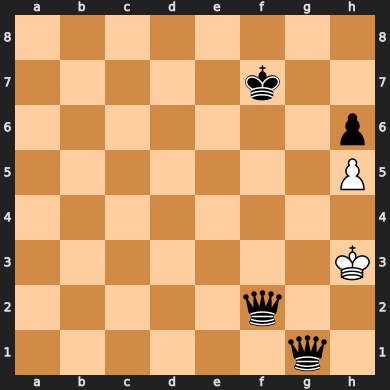

In [ ]:
# display(chess.Board(pgn[-1][-1]))


Now the following a bit messy piece of code actually takes all of the things above and makes a huuge dataset with all the things needed for our project (almost) ...

In [ ]:
## qua creo il dataset grosso
file = open("partite.csv", "w")

writer = csv.writer(file)

columns = ["Time", "Game", "Player", "Statistics", "Value"]
writer.writerow(columns)


# to do create queste cose così da poter iterare in questa roba della morte e creare un dataset di questo tipo
# https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/realwage.csv




lista_partite = []
gamecount = 0
count = 0   
for root,dirs, files in os.walk("games"):
    if str(root)  != "games":

        partita = f"Game{root[-6:]}"
        lista_partite.append(root[-6:])
        gamecount += 1
        
    row_written = 0
    flag = False
    row_1 = []
    row_2 = []
    row_3 = [] 
    row_4 = []
    row_5 = []
    row_6 = []
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        #print(filename)
        if filename.endswith(".txt") and (filename[0] == "w" or filename[0] == "b"): # abbiamo un carissimo file delle attività
        #leggiamo i battiti
            #print(f"processando {filename}")
            player = filename[0]
            activity = read_activity(f"{str(root)}/{filename}")
            # As explained in the markdown above on our strumentation TODO our smartwatches recorded the heartbeats at different time so we smoothed it out
            for hr, time in activity:
                row = [int(time), partita, player, "HR", int(hr)]
                
                
                if filename[0] == "w":
                    row_1.append(row)
                elif filename[0] == "b": 
                    row_2.append(row)
            
            row_written += 1
            
        elif filename.endswith(".pgn"):
            # #print(get_moves(f"{str(root)}/{filename}",), filename, partita)
            filename = filename[:-3] + "csv"
            #print(f"processando {filename}")
            
            
            with open(f"{str(root)}/{filename}", newline='') as f:
                
                pgn = []
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    tupla = eval(row[2])
                    pos = row[1]
                    lastpos = 0
                    
                    if "#" in row[1] or "Mate" in row[1]:
                        if "MateGiven" in row[1]:
                            pos = lastpos  
                        elif "-" in pos:
                            pos = -20
                            lastpos = pos
                        else:
                            pos = +20
                            lastpos = pos
                    elif float(row[1]) >= 20:
                        pos = 20
                    elif float(row[1]) <= -20:
                        pos = 20
                        # #print(row[1], pos)
                    pgn.append([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3])])
                    # #print([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3]) ])
                        
                print("aooo")
                pgn = pgn[1:]
                last_second = len(pgn) - 1
                    
                for second in range(len(pgn)):
                    
                    ev = pgn[second][1]
                    
                    ev = float(pgn[second][1])
                    
                    row = [second, partita, "w", "Evaluation", ev]
                    
                    row_3.append(row)
                    row = [second, partita, "b", "Evaluation", -ev]
                    row_4.append(row)
                    
                
                for second in range(len(pgn)):
                    
                    row = [second, partita, "w", "TimeUsed", int(pgn[second][2][0])]
                    row_5.append(row)
                    row = [second, partita, "b", "TimeUsed", int(pgn[second][2][1])]
                    row_6.append(row)
                    
                print("addr")
                row_written += 1
            
    print(row_written, partita)
    if row_written == 3:
        
        list_rows = [row_1,row_2,row_3,row_4, row_5, row_6]
        length = min([len(row) for row in list_rows])
        print("siuu")
        
        
        count = 0
        for i in range(6):
            
            for r in range(length):
                
                writer.writerow([count] + list_rows[i][r])
                count += 1
                
            row_written = False

print(lista_partite)



Actually we realised that a dataset made only of the moves could have come to use so we decided to create this one too with a bit more statistics related to each move, the dataset containes the following columns:
- **MoveS**              (Move in standard notation)
- **MovePGN**            (Move in PGN notation)
- **Player**             who made the move (Black or White)
- **TimeUsed**           (up until the move)
- **Time**               (value in seconds )
- **Evaluation**         (Evaluation of the position)
- **HRDelta**            (Delta of the HeartRate from the mean of the first ten 10 seconds -at rest-)
- **TPM**                (Time per move)
- **Board**              ([FEN](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) notation) to display the boards here on the notebook
- **Game**               (internal id of the game ( Game{Month}{Day}-{Number} ))
- **DeltaPos**           (Change in the position evaluation from the move before)
- **AbsHRAfter**         (Highest Absolute Value Change  of the Player who played the move ten seconds after the move)
- **AbsHRBefore**        (Highest Absolute Value Change  of the Player who played the move ten seconds before the move)
- **AbsHRAfter_altro**   (Highest Absolute Value Change  of the Player who did not play the move ten seconds after the move)
- **AbsHRBefore_altro**  (Highest Absolute Value Change  of the Player who did not play the move ten seconds before the move)

In [ ]:
## DATASET PER LE MOSSE


vialibera = False

gamecount = 0
count = 0   
partita = ""
with open("mosse.csv", "w") as file:
    writer = csv.writer(file)
    # TR: Time Remaining
    # T: Time in seconds from the beginning of the match
    # HRDelta: difference of the heart rate at the moment of the move
    # TPR: Time per move
    
    columns = ["MoveS","MovePGN", "Player", "TimeUsed", "Time", "Evaluation","HRDelta", "TPM", "Board", "Game", "DeltaPos", "AbsHRAfter","AbsHRBefore","AbsHRAfter_altro","AbsHRBefore_altro"]
    # move ok, board ok, player ok, tr ok, t ok, hrdelta ok, manca tpr
    writer.writerow(columns)
    file.close()

for root,dirs, files in os.walk("games"):
    if str(root)  != "games":
        partita = f"Game{root[-6:]}"
        gamecount += 1
        
    df = pd.read_csv("partite.csv")

    df = df.pivot_table(values='Value',
                            index='Time',
                            columns=['Game', 'Player', 'Statistics'])
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        
        #print(filename)
        
        #leggiamo i battiti
        
        if filename.endswith(".pgn"):
            vialibera = True
            filename = filename[:-3] + "csv"
            # print(f"processando {filename}")
            
        
            moves = get_moves(f"{str(root)}/{filename}")
            currpos = 0.0
            last_pos = 0.0
            lastbb = 0
            lastbw = 0
            added = 0
            ret = []
            # print(moves)
            with open(f"{str(root)}/{filename}", newline='') as f:
                pgn = []
                time_last_move_w = 0.0
                time_last_move_b = 0.0
                
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    if "#" in  row[1]:
                        if "-" in row[1]:
                            currpos = -20.0
                        elif "+" in row[1]:
                            currpos = 20.0
                    
                    else:
                        currpos = float(row[1]) 
                        if currpos > 20.0:
                            currpos = 20.0
                        elif currpos < -20.0:
                            currpos = -20.0
                    
                    diffw = 1
                    diffb = 1
                    move = eval(row[3])
                    abshrdopo = 0
                    abshrprima = 0
                    abshrprima_altro=0
                    abshrdopo_altro=0
                    if move != []:
                        trem = eval(row[2])
                        # aggiungi max_delta(5 secondi da quella mossa)
                        # aggiungi differenza di posizione di mossa in mossa
                        # togli mosse che clashano
                        for _ in move:
                            if added % 2 == 0:
                            
                                delta_pos = float(currpos) - last_pos
                                last_pos = float(currpos)
                                # else:
                                #     if "-" in currpos:
                                #         delta_pos = -20 - last_pos
                                #         last_pos = -20
                                #     elif "+" in currpos:
                                #         delta_pos = 20 - last_pos
                                #         last_pos = 20
                                try:
                                    battw = df[partita]["w"]["HR"][int(row[0])]
                                    battb_altro = df[partita]["b"]["HR"][int(row[0])]
                                    if math.isnan(battw):
                                        battw = lastbw
                                        battb_altro = lastbb
                                    lastbw = battw
                                    lastb_altro = battb_altro
                                    for i in range(5):
                                        ## ABSHR per 5 secondi dopo
                                        try: 
                                            print(partita)
                                            nbw = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            nbb_altro = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            
                                        except:
                                            pass
                                        else:
                                            nbw = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            ab = abs(abs(int(battw)) + abs(int(nbw)))
                                            abshrdopo = max( abshrdopo, ab)
                                            # if ab > abs(abshrdopo):
                                            #     abshrdopo = int(battw) - int(nbw)

                                            nb_altro = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            ab_altro = abs(abs(int(battb)) + abs(int(nbb_altro)))
                                            abshrdopo_altro = max( abshrdopo_altro, ab_altro)
                                            # if ab_altro > abs(abshrdopo_altro):
                                            #     abshrdopo_altro = int(battb) - int(nbb_altro)
                                        
                                        ## ABSHR per 5 secondi prima
                                        if int(row[0]) - i >= 0:
                                            nb = int(df[partita]["w"]["HR"][int(row[0]) - i])
                                            ab = abs(abs(int(battw)) + abs(int(nb)))
                                            abshrprima = max( abshrprima, ab)
                                            # if ab > abs(abshrprima):
                                            #     abshrprima = int(battw) - int(nb)

                                            nb_altro = int(df[partita]["b"]["HR"][int(row[0]) - i])
                                            ab_altro = abs(abs(int(battb)) + abs(int(nb_altro)))
                                            abshrprima_altro = max( abshrprima_altro, ab_altro)
                                            # if ab_altro > abs(abshrprima_altro):
                                            #     abshrprima_altro = int(battw) - int(nb_altro)

                                        else:
                                            abshrprima = 0
                                            abshrprima_altro = 0
                                    
                                    
                                except:
                                    battw = lastbw
                                    
                                
                                ret.append(moves[added] + [move,"w",trem[0],int(row[0]), currpos, battw, trem[0] - time_last_move_w, row[-1], partita,  min(abs(delta_pos), 20),abshrdopo,abshrprima, abshrdopo_altro, abshrprima_altro]) 
                                time_last_move_w = trem[0]
                                
                            else:
                            
                                delta_pos = last_pos - float(currpos)
                                last_pos = float(currpos)
                                    
                                # else:
                                #     if "-" in currpos:
                                #         delta_pos = -20 - last_pos
                                #         last_pos = -20
                                #     elif "+" in currpos:
                                #         delta_pos = 20 - last_pos
                                try:
                                    battb = df[partita]["b"]["HR"][int(row[0])]
                                    battb_altro = df[partita]["w"]["HR"][int(row[0])]
                                    if math.isnan(battb):
                                        battb = lastbb
                                        battb_altro = lastbb
                                    lastbb = battb
                                    lastb_altro = battb_altro
                                    for i in range(5):
                                        
                                        try: 
                                            nbb = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            nbb_altro = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            
                                        except:
                                            pass
                                        else:
                                            nbb = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            ab = abs(abs(int(battb)) + abs(int(nbb)))
                                            abshrdopo = max( abshrdopo, ab)
                                            # if ab > abs(abshrdopo):
                                            #     abshrdopo = int(battb) - int(nbb)

                                            nb_altro = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nbb_altro)))
                                            # if ab_altro > abs(abshrdopo_altro):
                                            #     abshrdopo_altro = int(battw) - int(nbb_altro)
                                                
                                            abshrdopo_altro = max( abshrdopo_altro, ab_altro)
                                            
                                            
                                        
                                        if int(row[0]) - i > 0:
                                            nb = int(df[partita]["b"]["HR"][int(row[0]) - i])
                                            ab = abs(abs(int(battb)) + abs(int(nb)))
                                            abshrprima = max( abshrprima, ab)
                                            # if ab > abs(abshrprima):
                                            #     abshrprima = int(battb) - int(nb)

                                            nb_altro = int(df[partita]["w"]["HR"][int(row[0]) - i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nb_altro)))
                                            abshrprima_altro = max( abshrprima_altro, ab_altro)
                                            # if ab > abs(abshrprima_altro):
                                            #     abshrprima_altro = int(battw) - int(nb_altro)
                                        else:
                                            abshrprima = 0
                                            abshrprima_altro = 0
                                        
                                except:
                                    battb = lastbb
                                    
                                
                                # min(abs(delta_pos), 20)
                                ret.append(moves[added] + [move,"b",trem[1],int(row[0]), currpos, battb, trem[1] - time_last_move_b, row[-1], partita, delta_pos, abshrdopo,abshrprima,abshrdopo_altro,abshrprima_altro])
                                time_last_move_b = trem[1]
                                
                            added += 1
                        

            if vialibera:            

                vialibera =False
                with open("mosse.csv", "a") as file:
                    writer = csv.writer(file)
                    
                    for move in ret:
                        writer.writerow(move)
                                    
                                   



Now we actually finished with all the preprocessing and dataset creation so we can start from the dataset mosse.
Last will be first as someone said a couple years back... Cringe sta roba la levo palese 

In [27]:
import pandas as pd
df = pd.read_csv("mosse.csv")
df

,MoveS,MovePGN,Player,TimeUsed,Time,Evaluation,HRDelta,TPM,Board,Game,DeltaPos,AbsHRAfter,AbsHRBefore,AbsHRAfter_altro,AbsHRBefore_altro
0,e4,['e2e4'],w,0.0,0,0.38,-1.0,0.0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,Game0814-2,0.38,2,0,12,0
1,e5,['e7e5'],b,0.1,1,0.55,-1.0,0.1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,Game0814-2,-0.17,2,0,2,0
2,f3,['f2f3'],w,5.9,6,-1.07,2.0,5.9,rnbqkbnr/pppp1ppp/8/4p3/4P3/5P2/PPPP2PP/RNBQKB...,Game0814-2,1.62,4,4,5,3
3,Nf6,['g8f6'],b,2.6,9,-0.74,2.0,2.5,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/5P2/PPPP2PP/RNBQ...,Game0814-2,-0.33,6,6,3,4
4,d3,['d2d3'],w,7.2,10,-1.44,1.0,1.3,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/3P1P2/PPP3PP/RNB...,Game0814-2,0.70,2,3,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,Qce1,['c1e1'],b,525.2,779,-20.00,8.0,1.8,8/5k2/7p/5K1P/8/8/3q4/4q3 w - - 8 66,Game0813-1,0.00,19,16,5,3
1886,Kg4,['f5g4'],w,255.6,781,-20.00,-3.0,2.0,8/5k2/7p/7P/6K1/8/3q4/4q3 b - - 9 66,Game0813-1,0.00,8,6,20,19
1887,Qdf2,['d2f2'],b,527.2,783,-20.00,11.0,2.0,8/5k2/7p/7P/6K1/8/5q2/4q3 w - - 10 67,Game0813-1,0.00,23,22,8,7
1888,Kh3,['g4h3'],w,258.2,786,-20.00,-4.0,2.6,8/5k2/7p/7P/8/7K/5q2/4q3 b - - 11 67,Game0813-1,0.00,8,9,23,23


Here we wanted to understand some things about the data collected so to start we saw what was the frequency of pieces moved,
Where:
- P: Pawns
- N: Knights
- B: Bishops
- Q: Queen
- R: Rooks
- K: King
- 0-0: Castles (either short or long)
- +: A move which consists in a check
- #: A move which consists of a checkmate
- =: A move which consists of a promotion of a pawn (usually a pawn promotes to a queen)

<BarContainer object of 10 artists>

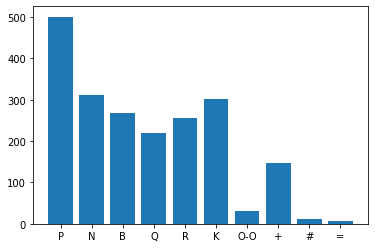

In [7]:
# Let's see what is the most played piece
mosse = df["MoveS"]
diz = {"P" : 0, "N" : 0,  "B" : 0, "Q" : 0,  "R" : 0, "K" : 0, "O-O": 0, "+" :0, "#": 0, "=":0 }
for mossa in mosse:
    
    if mossa[0].islower(): # è un pedone 
        diz["P"] += 1
    elif mossa[0] in list(diz.keys()):
        diz[mossa[0]] += 1
    if "+" == mossa[-1] or "#" in mossa[-1]:
        diz[mossa[-1]] += 1
    elif "=" in mossa:
        diz["="] += 1
    elif "O-" in mossa:
        diz["O-O"] += 1

plt.bar(list(diz.keys()),list(diz.values()),)

Now we plotted the distributions of the different columns of the dataframe

0.13362887692678316 -5.548624182131737e-26 3.176245489920899


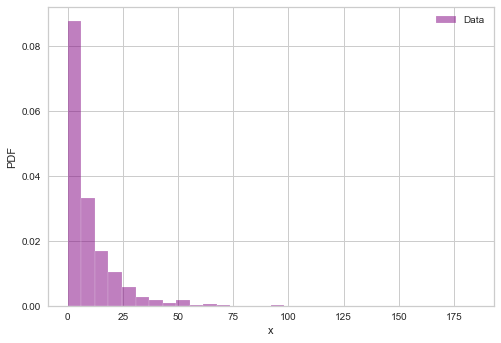

In [186]:
# # Freeze the fitted model
# from scipy import stats as st

# hat_alpha, hat_loc, hat_beta = st.gamma.fit(df["TPM"])
# print(hat_alpha, hat_loc, hat_beta)
# rv_fit  = st.gamma(a = hat_alpha, loc = hat_loc, scale = hat_beta)
# v_grid  = np.linspace(0, 100, num = 501)
# pdf_val = rv_fit.pdf(v_grid)
# plt.hist(df["TPM"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5,
#         label = "Data", bins = 30);
# # plt.plot(v_grid, pdf_val, '#fdc0cc', linewidth = 5,
# #         label = "Estimated PDF");
# plt.xlabel('x')
# plt.ylabel('PDF')
# plt.legend(loc='upper right');
# plt.show()

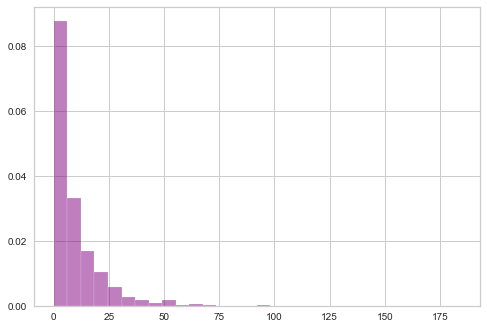

In [199]:
n, bins, patches = plt.hist(df["TPM"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)

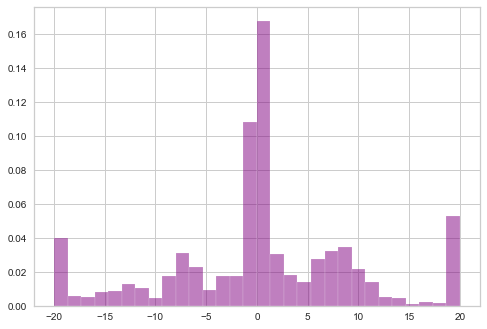

In [193]:
n, bins, patches = plt.hist(df["Evaluation"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)

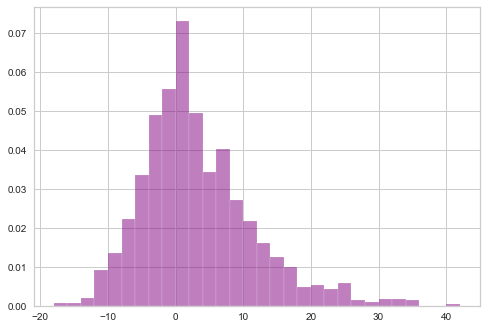

In [194]:
n, bins, patches = plt.hist(df["HRDelta"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)

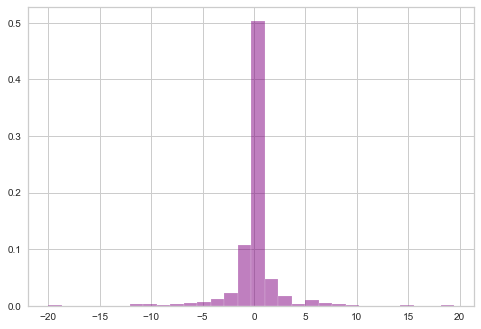

In [195]:
n, bins, patches = plt.hist(df["DeltaPos"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)

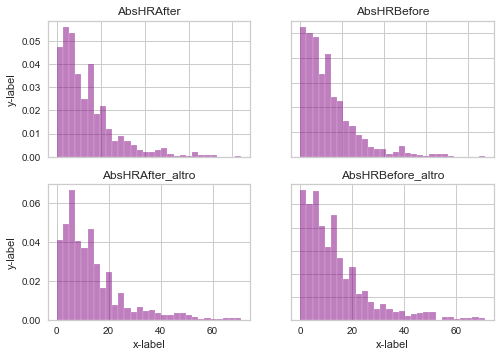

In [198]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(df["AbsHRAfter"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[0, 0].set_title('AbsHRAfter')
axs[0, 1].hist(df["AbsHRBefore"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[0, 1].set_title('AbsHRBefore')
axs[1, 0].hist(df["AbsHRAfter_altro"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[1, 0].set_title('AbsHRAfter_altro')
axs[1, 1].hist(df["AbsHRBefore_altro"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[1, 1].set_title('AbsHRBefore_altro')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


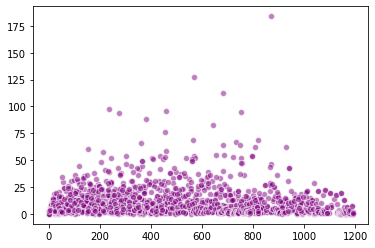

In [8]:
plt.scatter(df["Time"],df["TPM"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

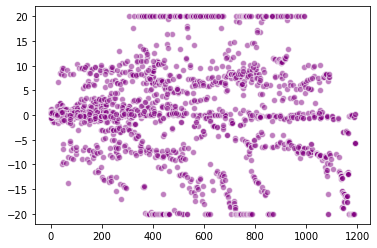

In [9]:
plt.scatter(df["Time"],df["Evaluation"],facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

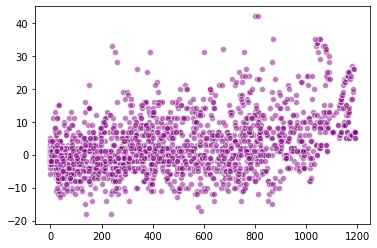

In [10]:
plt.scatter(df["Time"],df["HRDelta"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

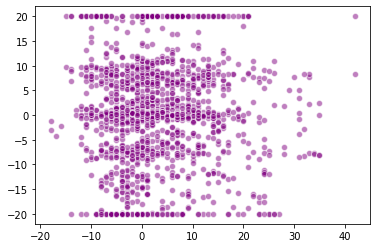

In [11]:
plt.scatter(df["HRDelta"], df["Evaluation"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

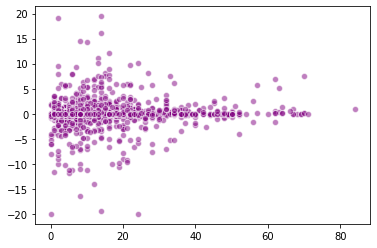

In [12]:
plt.scatter(df["AbsHRAfter"], df["DeltaPos"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")


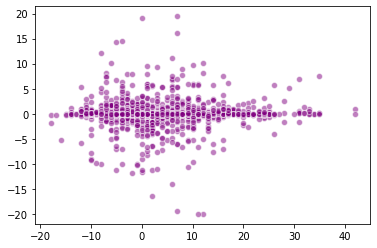

In [13]:
X = df['HRDelta']
Y = df['DeltaPos']
plt.scatter(X, Y, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

In [146]:
ncdf = df.copy()

Before going any further in any specific analysis we decided to remove the moves conflicting so as to isolate the heartrate fluctuations to the specific moves only without the possible influence of other moves played in a short amount of time (from 0 to 10 seconds after and from 0 to 10 seconds before).
For this purpose we added these moves to a conflict set and then dropped them altogether fro the dataset

In [147]:
conflict_time = 0
conflict_set = set()
for i, row in df.iterrows():
    for j, row2 in df.iloc[i+1:i+11].iterrows():
        if int(row2["Time"]) - int(row["Time"]) <= 10:
            conflict_set.add(i)
            conflict_set.add(j)

In [148]:
for el in list(conflict_set):
    try:
        ncdf = ncdf.drop(el)
    except:
        pass
ncdf

,MoveS,MovePGN,Player,TimeUsed,Time,Evaluation,HRDelta,TPM,Board,Game,DeltaPos,AbsHRAfter,AbsHRBefore,AbsHRAfter_altro,AbsHRBefore_altro
18,Nge2,['g1e2'],w,79.1,116,-0.64,-3.0,18.2,r1bn1rk1/ppp2ppp/5b2/4p3/4P3/2N2P2/PPP1N1PP/2K...,Game0814-2,0.58,7,6,20,24
19,c5,['c7c5'],b,59.8,139,1.28,3.0,23.0,r1bn1rk1/pp3ppp/5b2/2p1p3/4P3/2N2P2/PPP1N1PP/2...,Game0814-2,-1.92,7,9,6,5
20,Nd5,['c3d5'],w,103.7,164,1.02,-4.0,24.6,r1bn1rk1/pp3ppp/5b2/2pNp3/4P3/5P2/PPP1N1PP/2KR...,Game0814-2,0.26,8,8,9,12
21,Bg5+,['f6g5'],b,87.4,192,0.99,6.0,27.6,r1bn1rk1/pp3ppp/8/2pNp1b1/4P3/5P2/PPP1N1PP/2KR...,Game0814-2,0.03,16,12,7,5
30,Nd5,['f4d5'],w,186.6,293,-0.21,-6.0,13.8,r1br2k1/pp3ppp/2n5/2pN4/4P2P/8/PPP3P1/2KR1B1R ...,Game0814-2,0.56,12,14,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,Rxb3,['b8b3'],b,374.2,892,4.40,6.0,20.4,7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...,Game0529-1,-1.35,12,14,13,14
1731,Ke7,['f6e7'],b,401.9,949,6.18,12.0,11.5,4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...,Game0529-1,-0.16,24,25,27,26
1732,Rc1,['d1c1'],w,558.7,961,5.23,16.0,12.0,4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...,Game0529-1,0.95,32,35,19,21
1778,c4,['c2c4'],w,61.9,205,-8.46,-7.0,23.3,r1b2rk1/1pb2ppp/p1n1q3/4p3/2P5/3P1N2/PP3PPP/R1...,Game0813-1,2.04,15,14,9,9


So let's see how the heartrate graphs changed having isolated only the moves with out any conflict in the $[t -10,t+10]$ interval

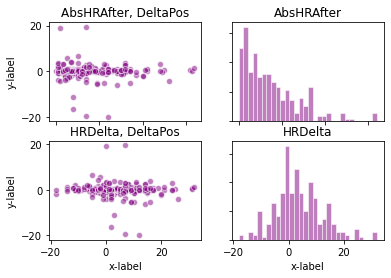

In [30]:

fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(ncdf["AbsHRAfter"], ncdf["DeltaPos"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")
axs[0, 0].set_title('AbsHRAfter, DeltaPos')
axs[0, 1].hist(ncdf["AbsHRAfter"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[0, 1].set_title('AbsHRAfter')
axs[1, 0].scatter(ncdf["HRDelta"], ncdf["DeltaPos"], facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")
axs[1, 0].set_title('HRDelta, DeltaPos')
axs[1, 1].hist(ncdf["HRDelta"], density = 1, facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove", bins = 30)
axs[1, 1].set_title('HRDelta')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [31]:
print(df["AbsHRAfter"].mean(), ncdf["AbsHRAfter"].mean())
print(df["HRDelta"].mean(), ncdf["HRDelta"].mean())



13.510582010582011 14.636363636363637
2.773015873015873 3.4734848484848486


In [32]:
df2 = pd.read_csv("partite.csv")
df2 = df2.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])

With this freshly changed and resized dataset we started with the clustering analysis, our premise for this analysis is that we won't get really intersting results.
Let me take this space to elaborate on our thoughts so far: as we started plotting our results we realized that our sample of players probably wasn't strong enough to compare to the chess understanding of an engine, which, for the sake of this project, we imagine it as a know-it-all arrogant person.
Now given that the engine, contrary to our players, doesn't miss anything and doesn't misevaluate any position is far ahead of players in general and even more ahead compared to relatively low-skilled level players. As an example of the different perceptions of the engine the following, we think, gives a pretty clear idea of the problem

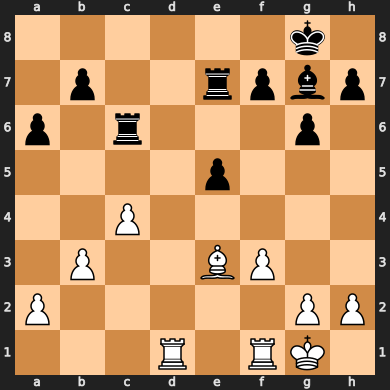

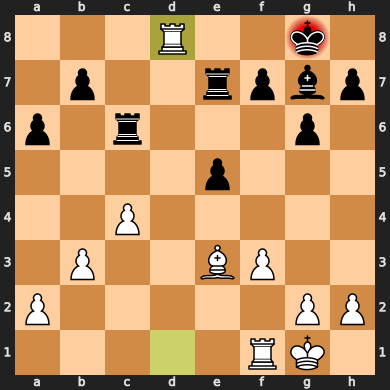

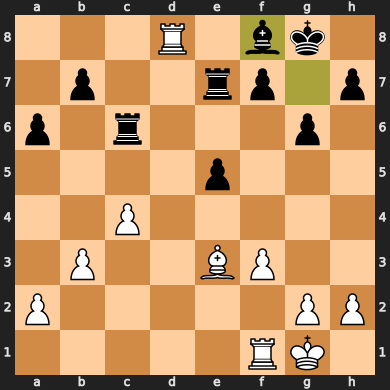

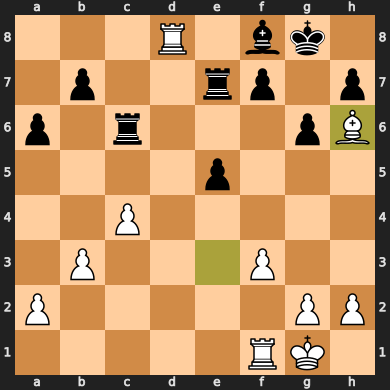

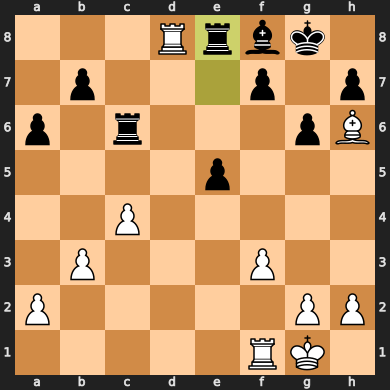

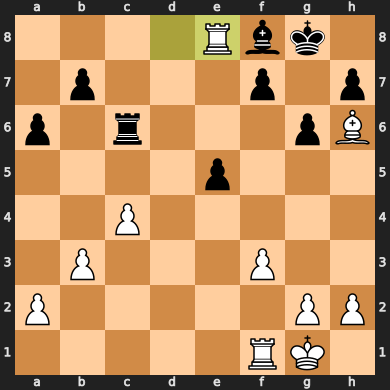

In [257]:
board = chess.Board("6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1 w - - 3 24")
display(board)
board.push(move = chess.Move.from_uci("d1d8"))
display(board)
board.push(move = chess.Move.from_uci("g7f8"))
display(board)
board.push(move = chess.Move.from_uci("e3h6"))
display(board)
board.push(move = chess.Move.from_uci("e7e8"))
display(board)
board.push(move = chess.Move.from_uci("d8e8"))
display(board)





Now it's pretty clear that whatever black moves white will checkmate on the next move and the game would end like this:

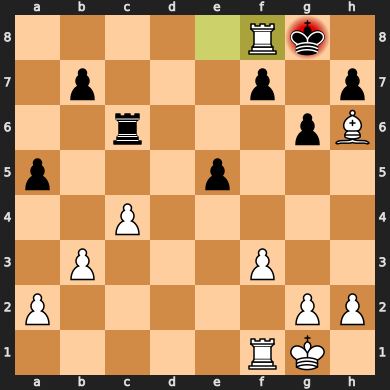

In [258]:
board.push(move = chess.Move.from_uci("a6a5"))
board.push(move = chess.Move.from_uci("e8f8"))
display(board)

Now the issue with this probably boring sequence of moves is that all the moves were forced and therefore the engine, as arrogant as he is considered it to be winned on the spot giving a position evaluation of 20 as if the game was winned already so in the following there his is take on the position, compared to what the players were probably thinking but first let's load the big dataset for a sec

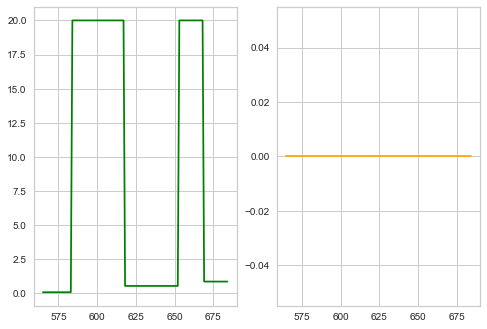

In [269]:
pos = df2["Game0816-5"]["w"]["Evaluation"].iloc[585-20:585+100].astype(float)
est_pos = np.zeros(shape=120)

t = np.arange(565,685)


f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, pos,color='green' )
# ax1.plot(t,eb0, color='orange')
ax2.plot(t, est_pos,color='orange')

The spikes of the engine, going from 0 to 20 represent every time white had an opportunity of completely closing the match and they go back at zero every time white missed it (spoiler: every time).
This is of course only one of the many times that the evaluation of the engine and the evaluation of the player differ (now the evaluation of the players thoght that maybe one was slightly ahead but the game was pretty balanced except for the subtle mate threat).
This is one of the reason that we expect this kind of analysis to bring us not really far.
But enough with chess (for now), let's go on!

So now as seen during classes and as we did in the first homework we thought of dividing the the moves in clusters using first K-means and then GMM, we actually don't expect neither to work particularly well but, given the strong assumptions of k-means, we expect GMM to a better choice.

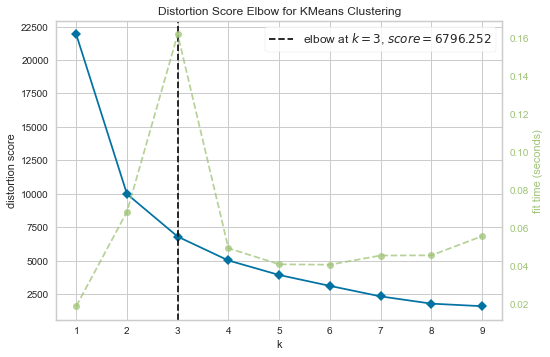

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

Delta_HR_pos = ncdf[['HRDelta','DeltaPos']]

n_components = np.arange(1, 10)
distortions = []
#we now fit the model using kmeans, trying different numbers of cluster
for i in n_components: 
    # selecting a random_state number we allow the reproducibility of the model
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) 
    kmeans.fit(Delta_HR_pos) 
    distortions.append(kmeans.inertia_)

visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(Delta_HR_pos)        
visualizer.show()



Using the elbow method we see that the number of components is three, a possible auspicable division could be opening, middle game and end game

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/4120860965.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/4120860965.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/4120860965.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

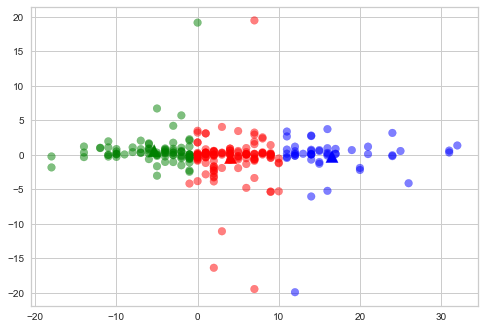

In [272]:
Delta_HR_pos = ncdf[['HRDelta','DeltaPos']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(Delta_HR_pos.HRDelta, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)

In [54]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

                             
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], X[:,2], c=labels, s=40, cmap='viridis')
    else:
        ax.scatter(X[:, 0], X[:, 1],X[:,2], s=40)
    # ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [57]:
Delta_HR_pos = df[['HRDelta','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

9
3


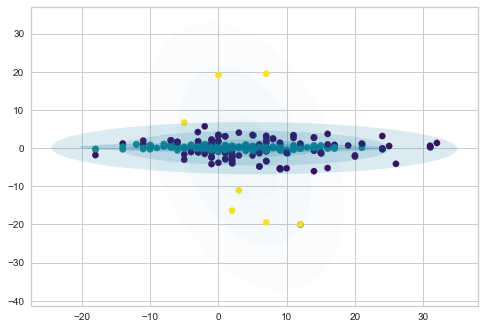

In [282]:
Delta_HR_pos = ncdf[['HRDelta','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
model = mixture.GaussianMixture(n_components = 3, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

plt.scatter(df_te.HRDelta, df_te.DeltaPos, s=40, cmap='viridis')
plot_gmm(model, Delta_HR_pos.to_numpy())

As expected this didn't work at all, K-means classified merely on the difference in heartrate, having three clusters, one centered at approximately zero, one made of the moves with a negative delta and one made of the moves with a positive delta.

GMM on the other hand actually did the opposite, the blue cluster classifies based solely on on the moves with zero change in Position, the purple one the ones with a medium change and the yellow ones with an higher change. 

clustering rispetto a posizione e massima variazione nei battiti nei 5 secondi dopo rispetto alla mossa

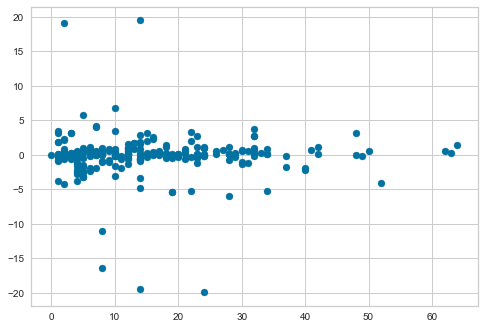

In [284]:
X = ncdf['AbsHRAfter']
Y = ncdf['DeltaPos']
plt.scatter(X,Y)

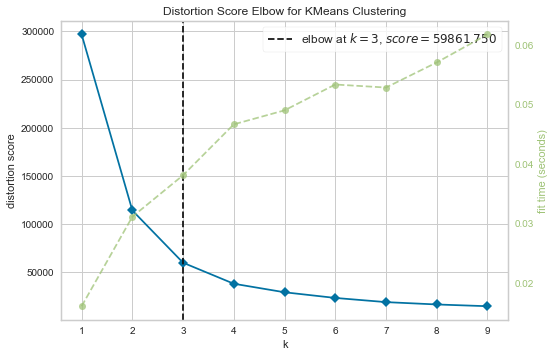

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [285]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]

n_components = np.arange(1, 10)
distortions = []
#we now fit the model using kmeans, trying different numbers of cluster
for i in n_components: 
    # selecting a random_state number we allow the reproducibility of the model
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) 
    kmeans.fit(Delta_HR_pos) 
    distortions.append(kmeans.inertia_)

visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(Delta_HR_pos)        
visualizer.show()

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/1960533299.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/1960533299.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_7235/1960533299.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

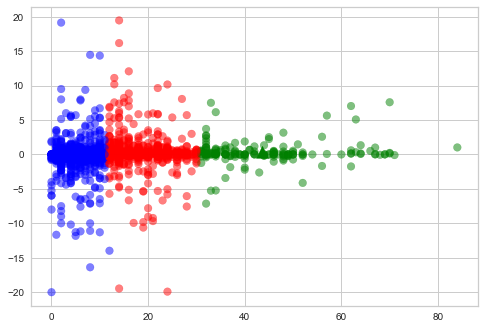

In [286]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(Delta_HR_pos.AbsHRAfter, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)

In [291]:
Delta_HR_pos = ncdf[['AbsHRAfter','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

7
5


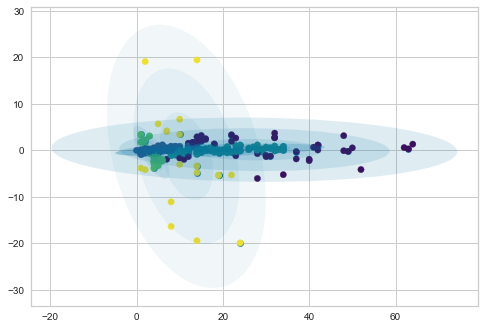

In [292]:
Delta_HR_pos = ncdf[['AbsHRAfter','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
model = mixture.GaussianMixture(n_components = 5, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

plt.scatter(df_te.AbsHRAfter, df_te.DeltaPos, s=40, cmap='viridis')
plot_gmm(model, Delta_HR_pos.to_numpy())

Now we tried pretty much the same analysis as before but this time, obviously using 5 components makes everything more chaotic so we didn't manage to make much of sense of this one either

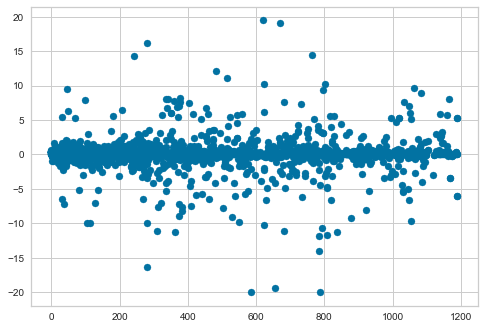

In [293]:
X = df['Time']
Y = df['DeltaPos']
plt.scatter(X,Y)

In [145]:
Delta_HR_pos = ncdf[['AbsHRBefore','DeltaPos','TPM']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_

cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
cen_z = [i[2] for i in centroids]

# Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
# Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# Delta_HR_pos['cen_z'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
# plt.scatter(Delta_HR_pos.AbsHRBefore, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
# plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)
# fig = plt.figure(figsize=(26,6))
# ax = fig.add_subplot(131, projection='3d')
# ax.scatter(Delta_HR_pos.AbsHRBefore, Delta_HR_pos.DeltaPos, Delta_HR_pos.Time, c=Delta_HR_pos.c, s=15)
# ax.set_xlabel('Attack')
# ax.set_ylabel('Defense')
# ax.set_zlabel('HP')
# plt.show()
import plotly.express as px
fig = px.scatter_3d(Delta_HR_pos, x='TPM', y='AbsHRBefore', z='DeltaPos', color = Delta_HR_pos.c)
fig.show()

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_3156/1592970685.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_3156/1592970685.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
Delta_HR_pos = ncdf[['AbsHRBefore','DeltaPos', 'Time']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

8
2


In [71]:

model = mixture.GaussianMixture(n_components = 2, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

fig = px.scatter_3d(df_te, x='Time', y='AbsHRBefore', z='DeltaPos', color = lebll)
fig.show()
# plot_gmm(model, Delta_HR_pos.to_numpy())

Still, even with the 3-Dimensional scatter plot everything stays pretty much the same.
This time for 3D GMM the moves were classified solely by time, this could probably be a good classification of endgame

In [35]:
# dff = df[["Time","AbsHRBefore", "AbsHRAfter", "DeltaPos", "HRDelta", "Game"]]
dff = ncdf[["AbsHRBefore","AbsHRAfter", "MoveS", "MovePGN","Time", "DeltaPos", 'Game', "Board",'Evaluation','AbsHRBefore_altro','AbsHRAfter_altro','Player']]
dff

,AbsHRBefore,AbsHRAfter,MoveS,MovePGN,Time,DeltaPos,Game,Board,Evaluation,AbsHRBefore_altro,AbsHRAfter_altro,Player
18,6,7,Nge2,['g1e2'],116,0.58,Game0814-2,r1bn1rk1/ppp2ppp/5b2/4p3/4P3/2N2P2/PPP1N1PP/2K...,-0.64,24,20,w
19,9,7,c5,['c7c5'],139,-1.92,Game0814-2,r1bn1rk1/pp3ppp/5b2/2p1p3/4P3/2N2P2/PPP1N1PP/2...,1.28,5,6,b
20,8,8,Nd5,['c3d5'],164,0.26,Game0814-2,r1bn1rk1/pp3ppp/5b2/2pNp3/4P3/5P2/PPP1N1PP/2KR...,1.02,12,9,w
21,12,16,Bg5+,['f6g5'],192,0.03,Game0814-2,r1bn1rk1/pp3ppp/8/2pNp1b1/4P3/5P2/PPP1N1PP/2KR...,0.99,5,7,b
30,14,12,Nd5,['f4d5'],293,0.56,Game0814-2,r1br2k1/pp3ppp/2n5/2pN4/4P2P/8/PPP3P1/2KR1B1R ...,-0.21,10,11,w
...,...,...,...,...,...,...,...,...,...,...,...,...
1725,14,12,Rxb3,['b8b3'],892,-1.35,Game0529-1,7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...,4.40,14,13,b
1731,25,24,Ke7,['f6e7'],949,-0.16,Game0529-1,4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...,6.18,26,27,b
1732,35,32,Rc1,['d1c1'],961,0.95,Game0529-1,4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...,5.23,21,19,w
1778,14,15,c4,['c2c4'],205,2.04,Game0813-1,r1b2rk1/1pb2ppp/p1n1q3/4p3/2P5/3P1N2/PP3PPP/R1...,-8.46,9,9,w


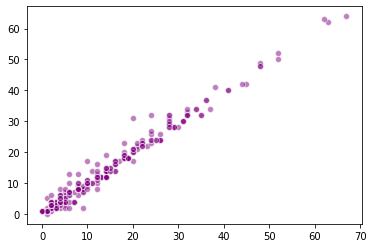

In [36]:
plt.scatter(dff['AbsHRBefore'],dff['AbsHRAfter'],facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")

On the above graph we can actually see the scatter plot of ABSHRBefore and ABSHRAfter, so we thought of fitting a linear regression model to predict the Absolute Highest Delta after the move using the Absolute Highest Delta before the move as the sole explanatory variable

In [37]:
#The Ordinary Least Squares function from the statsmodel library
import statsmodels.formula.api as smf

fitd = smf.ols( formula = ' AbsHRAfter ~ AbsHRBefore', data = dff).fit()
print(fitd.summary())

                            OLS Regression Results                            
Dep. Variable:             AbsHRAfter   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.104e+04
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          3.29e-216
Time:                        10:16:51   Log-Likelihood:                -540.57
No. Observations:                 264   AIC:                             1085.
Df Residuals:                     262   BIC:                             1092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5117      0.177      2.884      

Model estimated coefficients are $\widehat{\beta}_1 = 0.9813$ and $\widehat{\beta}_0 = 0.5117$. 
The regression function is $\widehat{\mu} = \widehat{\beta}_0 + \widehat{\beta}_1 x = 0.51 + 0.98x $ indicating that the predicted women’s record time increases by 5.87 minutes for every additional kilometer of distance. Let's derive the coefficients using the formulas $\widehat{\beta}_1 = \frac{s_{xy}}{s^2_x}$ and $\widehat{\beta}_0 = \bar{y} - \widehat{\beta}_1 \bar{x}$

The $R^2$ for the model is 0.977, the same as the adjusted-$R^2$. 

In [119]:
x = ncdf["AbsHRBefore"]
y = ncdf["AbsHRAfter"]

In [120]:
s2_x  = np.cov(x, y)[0,0]
s_xy  = np.cov(x, y)[0,1]
beta1 = s_xy/s2_x
beta0 = np.mean(y) - beta1*np.mean(x)
print(beta1, beta0)

0.981289863546595 0.5117368125868911


In [121]:
yhat = beta0 + beta1*x
#yhat = fitd.predict()
yhat.head(5)

18     6.399476
19     9.343346
20     8.362056
21    12.287215
30    14.249795
Name: AbsHRBefore, dtype: float64

In [122]:
e = y - yhat
e.head(5)

18    0.600524
19   -2.343346
20   -0.362056
21    3.712785
30   -2.249795
dtype: float64

In [123]:
n   = len(x)
SSE = np.sum(e**2)
s2  = SSE/(n-2)
print(s2)

3.5429815876467075


In [124]:
var_beta1 = s2/((n-1)*s2_x)
sd_beta1  = np.sqrt(var_beta1)
var_beta0 = s2*np.sum(x**2)/(n*np.sum((x-np.mean(x))**2))
sd_beta0  = np.sqrt(var_beta0)
print(sd_beta1, sd_beta0)

0.009338035704221034 0.17744501677227814


In [125]:
s2_y = np.cov(x, y)[1,1] 
r    = s_xy/(np.sqrt(s2_x)*np.sqrt(s2_y))
print(r)

0.9883441865902888


In [126]:
R2   = r**2
print(R2)

0.9768242311668196


In [127]:
adj_R2 = 1 - ((n-1)/(n-2))*(1 - R2)
print(adj_R2)

0.9767357740338686


In [128]:
TSS = np.sum((y - np.mean(y))**2)
print(TSS)

40053.090909090904


In [129]:
SSR = np.sum((yhat - np.mean(y))**2)
print(SSR)

39124.82973312745


In [130]:
SSE_v2 = TSS - SSR
print(SSE_v2 - SSE)    # should be zero

1.546140993013978e-11


In [131]:
R2_v2 = SSR/TSS
print(R2_v2)

0.9768242311668195


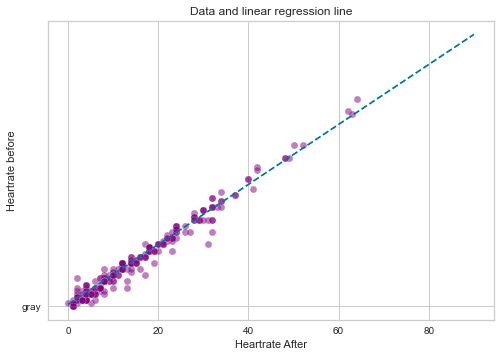

In [134]:
plt.title('Data and linear regression line')
plt.ylabel('Heartrate before')
plt.xlabel('Heartrate After')

x = dff['AbsHRAfter']
y = dff['AbsHRBefore']
xx = np.linspace(0,90,1000)
#we write y as a function of x, having computed the regression function 
yy = 0.58 + 0.97*xx
#first we plot the simple linear regression, then with the scatter method we plot the points
plt.plot(xx,yy, '--', "gray" )
plt.scatter(x,y,facecolor='purple', edgecolor = 'white', alpha=0.5, label = "TimePerMove")
plt.show()

... and the residuals ...

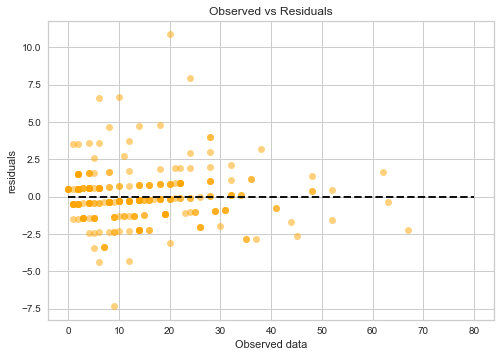

In [135]:
plt.title("Observed vs Residuals") 
plt.xlabel("Observed data") 
plt.ylabel("residuals") 
plt.plot(y,e, "o", color = 'orange', alpha = 0.5) 
plt.plot([0,80], [0, 0], '--', lw=2, color = 'k')
plt.show()

Let's derive the $t$ statistic for the test $H_0: \beta_0=0$ versus $H_1: \beta_0 \neq 0$ together with the associated p-value and confidence interval. Remember that $t = \frac{\widehat{\beta}_0}{\widehat{se}(\widehat{\beta}_0)} $, p = $ P(t_{n-1} > |t_{oss}|)$ and CI = $\widehat{\beta}_0 \pm t_{n-1, 1-\alpha/2} \cdot \widehat{se}(\widehat{\beta}_0)$.

In [137]:
t_stat_beta0 = beta0/sd_beta0
t_stat_beta0

-0.9908274863614474

In [138]:
from scipy import stats as st
p_value_beta0 = 2*(1 - st.t.cdf(t_stat_beta0, n-1))
print(p_value_beta0)

1.6773194729158583


In [139]:
alpha = 0.05
CI_lower_beta0 = beta0 - st.t.ppf(1 - alpha/2, n-1)*sd_beta0
CI_upper_beta0 = beta0 + st.t.ppf(1 - alpha/2, n-1)*sd_beta0
print(CI_lower_beta0, CI_upper_beta0)

-0.5252110694550389 0.17357626958335648


In [140]:
t_stat_beta1 = beta1/sd_beta1
t_stat_beta1

106.60156519768044

In [141]:
p_value_beta1 = 2*(1 - st.t.cdf(t_stat_beta1, n-1))
print(p_value_beta1)

0.0


In [142]:
CI_lower_beta1 = beta1 - st.t.ppf(1 - alpha/2, n-1)*sd_beta1
CI_upper_beta1 = beta1 + st.t.ppf(1 - alpha/2, n-1)*sd_beta1
print(CI_lower_beta1, CI_upper_beta1)

0.9770623964329801 1.0138360474505925


We now aim at computing the $F$ statistic, that equals $\frac{(TSS-SSE)/p}{SSE/[n-(p+1)]}$. But in the univariate model $p=1$ so $f = SSR/s^2$. We also evaluate the p-value, $P(F > |f_{oss}|)$

In [ ]:
f = SSR/s2
print(f)

In [ ]:
p_value_model = 2*(1 - st.f.cdf(t_stat_beta1, 1, n-2))
print(p_value_model)

In [39]:
## BLUNDERS o OTTIME MOSSE
ndff =  dff[["AbsHRBefore","AbsHRAfter", "MoveS", "MovePGN","Time", "DeltaPos", 'Game', "Board",'Evaluation','AbsHRBefore_altro','AbsHRAfter_altro','Player']]



# ANALISI QUALITATIVA
Now let's try to see if it makes any sense to do a qualitative analysis.
We thought to carry this out in the following way:
First of all we want to find, among the already reduced moves, the ones that changed the position evaluation the most.

In the following cell, for each move we appended to the corresponding lists the following:
-  Highest difference from the heartrate of the player that made the move at time $ t $ in the interval $[t-10 , \; t]$
-  Highest difference from the heartrate of the player that made the move at time $ t $ in the interval $[t , \; t + 10]$
-  Highest difference from the heartrate of the player that didn't make the move at time $ t $ in the interval $[t-10 , \; t]$
-  Highest difference from the heartrate of the player that didn't make the move at time $ t $ in the interval $[t , \; t + 10]$

In the lists:
- `perdenti_prima`
- `perdenti_dopo`
- `vincenti_prima`
- `vincenti_dopo`

In the same cell we also append to `lista_c` all the moves that caused a change in absolute value, in the evaluation of the position of more than 3.0,
we expect this moves to be anyone of the following: good moves that gave a significant advantage to a player, bad mistakes that gave an advantage to the opponent. Now it's also important to underline that there could be changes in the position that signify potential opportunities that weren't exploited
from the players, this could depend on a number of factors like: overlooking a particular move, not understanding well the current position, lack of time or simply a lower skill level.

We therefore believe that the position evaluation of a chess engine would look a lot more alike to the position evaluation of a really expert player and obviously sees things in a very different way from the way our players did in the games.

Nonetheless we decided to analyse these key moments in the following cells asking each player how he felt during the game about that particular move or sequence of moves (also called _lines_ in chess)

We also displayed some of the boards that met the aforementioned conditions, together with the position evaluation, position evaluation delta.


(188, AbsHRBefore                                                         29
AbsHRAfter                                                          28
MoveS                                                              Ba5
MovePGN                                                       ['b4a5']
Time                                                               537
DeltaPos                                                         -6.05
Game                                                        Game0816-1
Board                3rr3/pk3ppp/2R5/b3P3/4N3/4P3/PP4PP/2R3K1 w - -...
Evaluation                                                        7.25
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 188, dtype: object)


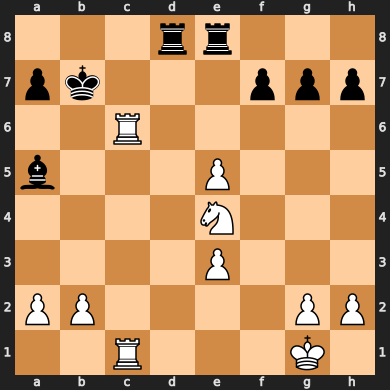

(431, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                               b5
MovePGN                                                       ['b7b5']
Time                                                               767
DeltaPos                                                         -3.83
Game                                                        Game0813-4
Board                r1b2r1k/2p4p/p2p1p2/qp1Q1N1B/4PPP1/P1N2n2/1PP4...
Evaluation                                                       14.28
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 431, dtype: object)


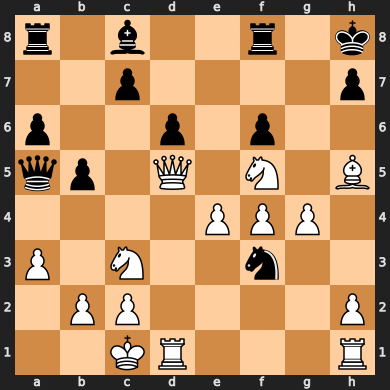

(492, AbsHRBefore                                                          4
AbsHRAfter                                                           8
MoveS                                                             Qxc6
MovePGN                                                       ['b6c6']
Time                                                               279
DeltaPos                                                        -16.38
Game                                                        Game0817-2
Board                r6N/1p1k2p1/p1q1p2p/3pn3/1b5P/2Q1B3/PPP2PP1/R3...
Evaluation                                                       10.44
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    17
Player                                                               b
Name: 492, dtype: object)


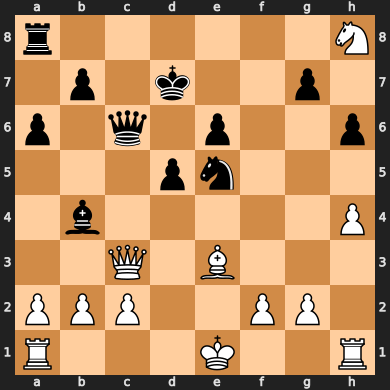

(1084, AbsHRBefore                                                         22
AbsHRAfter                                                          22
MoveS                                                              Qc3
MovePGN                                                       ['b3c3']
Time                                                               354
DeltaPos                                                          3.36
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbn2/1pb3B1/4PPn1/2QB3N/PPPN2PP...
Evaluation                                                       -6.77
AbsHRBefore_altro                                                   35
AbsHRAfter_altro                                                    36
Player                                                               w
Name: 1084, dtype: object)


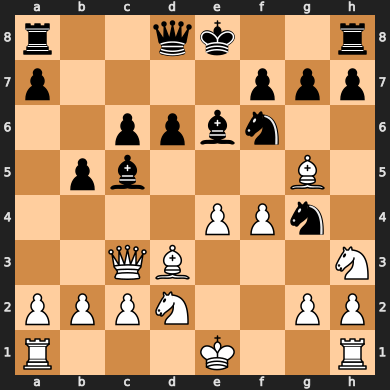

(1249, AbsHRBefore                                                          5
AbsHRAfter                                                           2
MoveS                                                              Qh4
MovePGN                                                       ['e7h4']
Time                                                               656
DeltaPos                                                         -4.18
Game                                                        Game0814-1
Board                r4rk1/pp4pp/2p5/4Rn2/7q/1P4QP/PBP2PP1/R5K1 w -...
Evaluation                                                        7.73
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     9
Player                                                               b
Name: 1249, dtype: object)


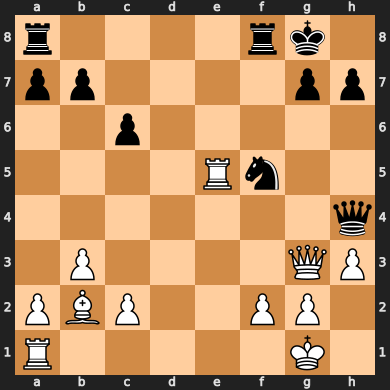

(1356, AbsHRBefore                                                         24
AbsHRAfter                                                          24
MoveS                                                              Re7
MovePGN                                                       ['d7e7']
Time                                                               585
DeltaPos                                                        -19.92
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1 ...
Evaluation                                                          20
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1356, dtype: object)


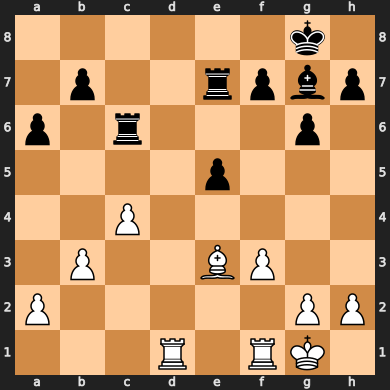

(1367, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Re3
MovePGN                                                       ['e1e3']
Time                                                               821
DeltaPos                                                          4.03
Game                                                        Game0816-5
Board                6k1/1p2r1b1/p1r4p/5pp1/2P1p2P/1P2RPB1/P5P1/3R2...
Evaluation                                                        -3.4
AbsHRBefore_altro                                                   30
AbsHRAfter_altro                                                    33
Player                                                               w
Name: 1367, dtype: object)


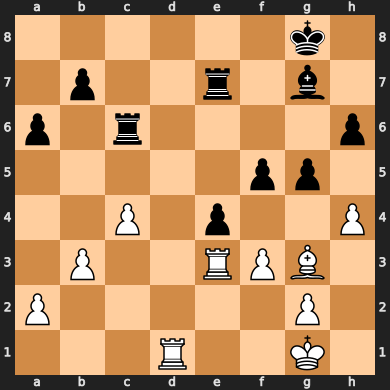

(1530, AbsHRBefore                                                         32
AbsHRAfter                                                          34
MoveS                                                            Bxf2+
MovePGN                                                       ['c5f2']
Time                                                               136
DeltaPos                                                         -5.23
Game                                                        Game0816-3
Board                r1bqk1nr/3p1ppp/p1p5/4N3/4P3/8/PPP2bPP/RNBQK2R...
Evaluation                                                        5.83
AbsHRBefore_altro                                                    3
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 1530, dtype: object)


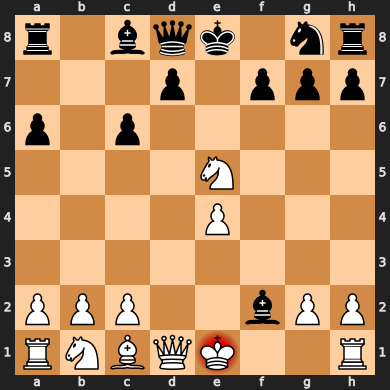

(1547, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             dxc6
MovePGN                                                       ['d5c6']
Time                                                               454
DeltaPos                                                           6.7
Game                                                        Game0816-3
Board                r1b2k1r/5ppp/p1P3q1/8/5Bn1/2N2NK1/PPP3PP/R2QR3...
Evaluation                                                        4.34
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     7
Player                                                               w
Name: 1547, dtype: object)


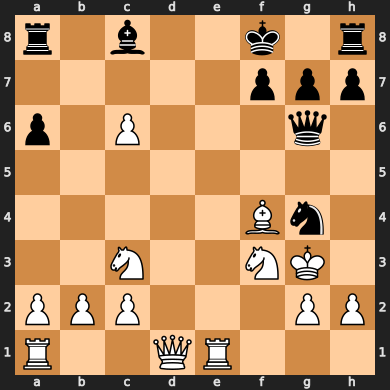

In [40]:
perdenti_prima = []
perdenti_dopo = []
vincenti_prima = []
vincenti_dopo = []
lista_c = []
c = 0

for row in ndff.iterrows():
    
    if abs(row[1][5]) > 3.0:
        
        lista_c.append(row[1])
        
        if c in [0,8,9,10,12,17,21,22,24]: #piccolo spoiler sono le partite che analizzeremo dopo
            print(row)
            display(chess.Board(row[1]["Board"]))
        c += 1
        if (row[1][11] == 'b' and '-' in str(row[1][8])) or (row[1][11] == 'w' and '-'  not in str(row[1][8])):
            vincenti_prima.append(row[1][0]) 
            vincenti_dopo.append(row[1][1])
            perdenti_prima.append(row[1][9])
            perdenti_dopo.append(row[1][10])
            
        else:
            perdenti_prima.append(row[1][0]) 
            perdenti_dopo.append(row[1][1])
            vincenti_prima.append(row[1][9])
            vincenti_dopo.append(row[1][10])


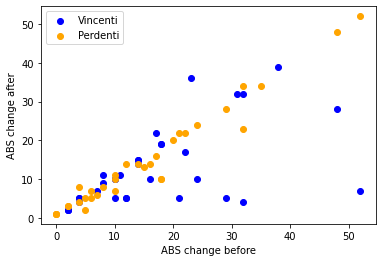

In [10]:
# Here we displayed the scatter plot of the "winners" vs the "losers" relative to each move, with their heart reate before and after the move
plt.scatter(vincenti_prima, vincenti_dopo, color = "blue")
plt.scatter(perdenti_prima, perdenti_dopo, color = 'orange')
plt.ylabel("ABS change after")
plt.xlabel("ABS change before")
plt.legend(["Vincenti","Perdenti"])
plt.show()


This suggests that a good move or more in general a move that brings you an advantage might, on average, cause an decrease in the heartrate.

In [22]:
# Let's load the big dataset too
df2 = pd.read_csv("partite.csv")
df2 = df2.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])


old = pd.read_csv("mosse.csv")
df2.head(10)

Game       Game0529-1                                        Game0529-2       \
Player              b                        w                        b        
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed Evaluation   HR   
Time                                                                           
0               -0.57 -2.0      0.0       0.57  4.0      0.0      -0.57 -3.0   
1               -0.57 -1.0      0.0       0.57  3.0      0.0      -0.57 -3.0   
2               -0.57 -2.0      0.0       0.57  2.0      0.0      -0.57 -2.0   
3               -0.45 -1.0      3.0       0.45  1.0      3.0      -0.43 -2.0   
4               -0.45  0.0      3.0       0.45  0.0      3.0      -0.33 -1.0   
5               -0.37  1.0      3.0       0.37 -1.0      3.0      -0.51  2.0   
6               -0.37  1.0      3.0       0.37 -1.0      3.0      -0.51  3.0   
7               -0.24  3.0      6.0       0.24 -1.0      6.0      -0.51  4.0   
8               -0.24  3.0      6.0       0.24 -1.0      6.0      -0.44  4.0   
9               -0.37  3.0      6.0       0.37  0.0      6.0      -0.44  3.0   

Game                            ... Game0817-3                           \
Player                       w  ...          b          w                 
Statistics TimeUsed Evaluation  ...   TimeUsed Evaluation   HR TimeUsed   
Time                            ...                                       
0               0.0       0.57  ...        0.0       1.25  0.0      0.0   
1               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
2               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
3               3.0       0.43  ...        0.0       1.25 -1.0      0.0   
4               3.0       0.33  ...        0.0       1.25 -1.0      0.0   
5               4.0       0.51  ...        0.0       1.25 -1.0      0.0   
6               4.0       0.51  ...        0.0       1.25 -1.0      0.0   
7               4.0       0.51  ...        0.0       1.25 -1.0      0.0   
8               4.0       0.44  ...        0.0       1.25  3.0      0.0   
9               4.0       0.44  ...        9.0       0.03  6.0      9.0   

Game       Game0817-4                                         
Player              b                        w                
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed  
Time                                                          
0               -0.40  1.0      0.0       0.40  4.0      0.0  
1               -0.45  0.0      1.0       0.45  3.0      1.0  
2               -0.31 -1.0      1.0       0.31  1.0      1.0  
3               -0.31 -1.0      1.0       0.31  1.0      1.0  
4               -0.25  1.0      3.0       0.25  0.0      3.0  
5               -0.25  1.0      3.0       0.25  0.0      3.0  
6               -0.25  2.0      3.0       0.25  0.0      3.0  
7               -0.25  2.0      3.0       0.25  0.0      3.0  
8               -0.22  1.0      4.0       0.22 -1.0      4.0  
9               -0.22  0.0      4.0       0.22 -1.0      4.0  

[10 rows x 132 columns]

In [21]:
## simple staff to get the next move using the old version of the dataset where conflicting moves weren't removed 
def get_next_move(i):
    return old.iloc[i+1]

def get_prev_move(i):
    return old.iloc[i-1]

Now we start to really analyse the nine positions you saw above and what happened with the heart rate in situations when there was a significant change in the position evaluation,
a change greater than three often means that a player has a huge  edge (like having a knight or a bishop more than your opponent)

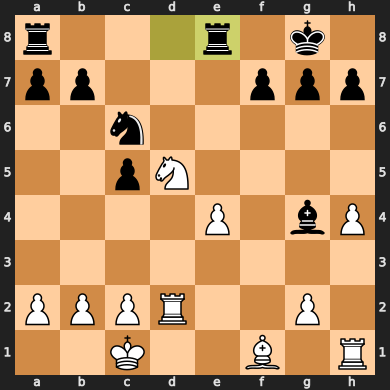

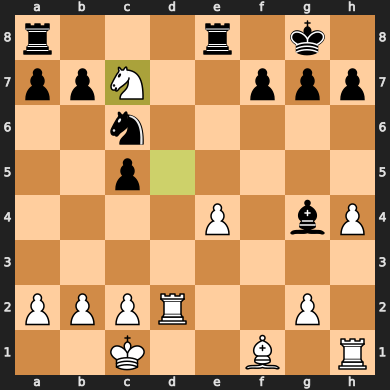

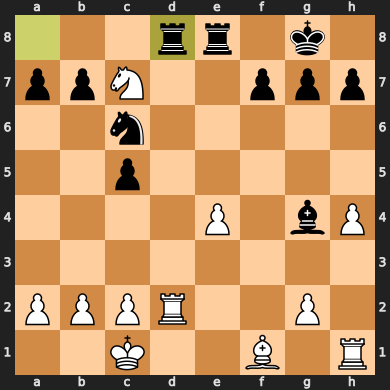

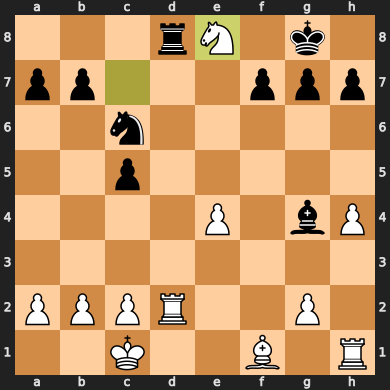

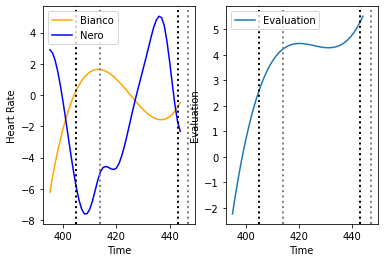

In [26]:
from scipy.interpolate import UnivariateSpline

ind = 0 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+40]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+40]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+40].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


When asked about this position black missed the idea of the potential double attack on the king and the rook and therefore moved the bishop, that covered the square d6 where the knight gave the double attack after all.
White instead said that he was planning on playing that move as soon as it would be possible and played it as soon as it had the chance:
We can see that between the first and the second move i.e. the error and the realization of white advantage, Black's heart rate continued its descending trend until right after this four moves.
White heart rate, that was exactly at his first10seconds-mean seconds after the move, after a significant increase in the interval in which he had to punish black for his mistake had an increase in the heart rate, which right after went to a downward trend.
White went on to win this one.

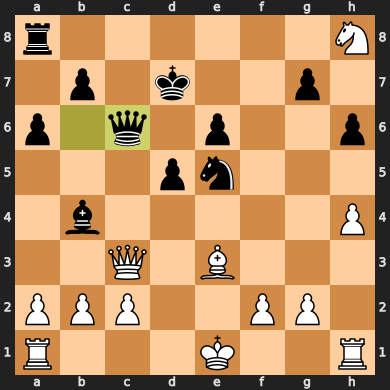

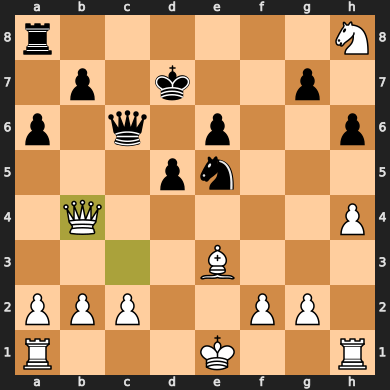

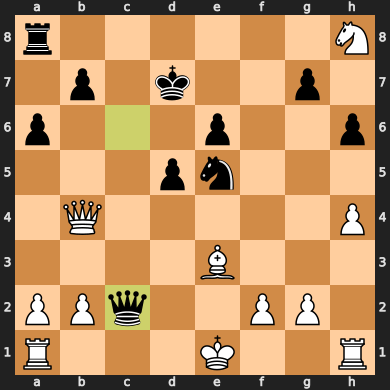

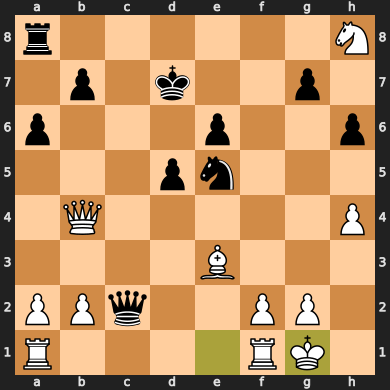

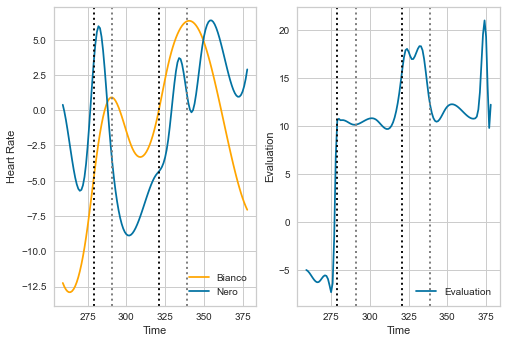

In [324]:
from scipy.interpolate import UnivariateSpline


ind = 9 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


In this occasion instead black was in clear advantage, a move away from winning white's queen, made a really bad mistake.
About this case black said that as soon as he moved he realised that he made a terrible mistake throwing completely away the game, his heart went on to go on a pretty steep dive.
White's heart rate instead was increasing right after black mistake.
After this both the heart rates went up to approximately +5 following a similar trend. Then afterwards white's heartrate (who was still winning) decreased and black's kept oscillating around that values
White went on to win the game.

Game0816-3


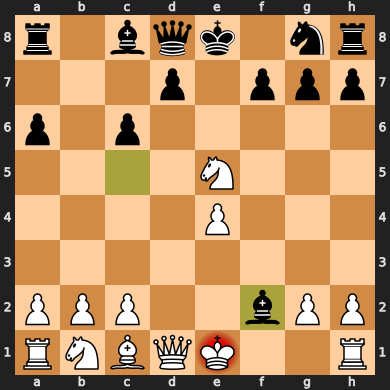

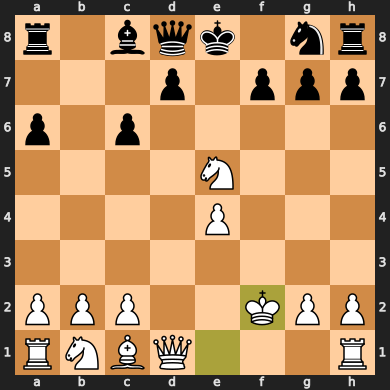

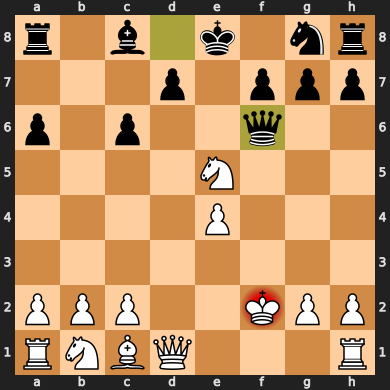

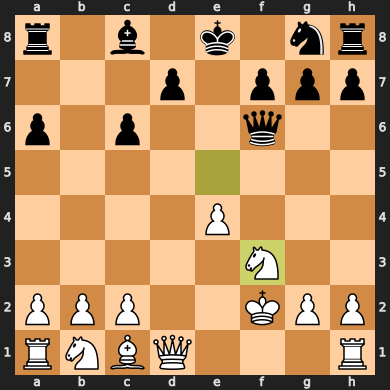

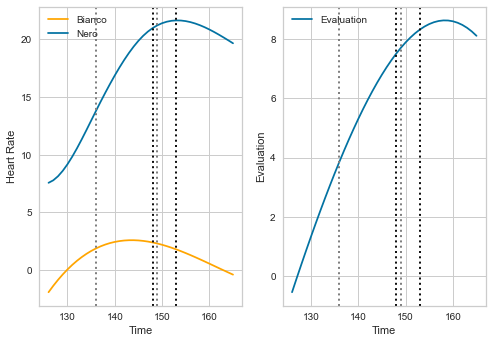

In [333]:
from scipy.interpolate import UnivariateSpline


ind = 22 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]
print(partita)



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+30]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+30]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+30].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


This one instead happened pretty early on in the game, still in the opening phase where most of the pieces weren't developed, after only 2 minutes (total) of play.
Black went on to sacrifice a piece, a very risky move in chess consisting of giving up a piece to either gain it back after a sequence of moves, go for an attack or simply gain momentum (or all of the above).

In this case black thought that after he sacrificed his bishop he could take back the kinght after the check on the king. Black didn't notice that the knight could come back and cover the check conisting in the lose of a full piece from black.

Black's heart rate went straight up after the sacrifice and stabilized as soon as he realized his sacrifice didn't work

White saw it as soon as he sacrificed and he didn't have a huge change in his trend

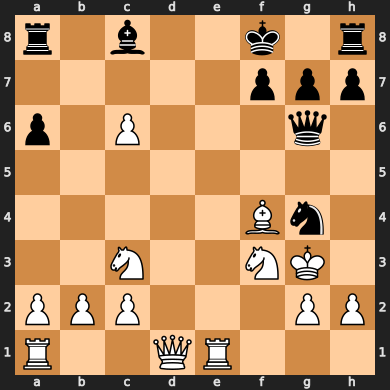

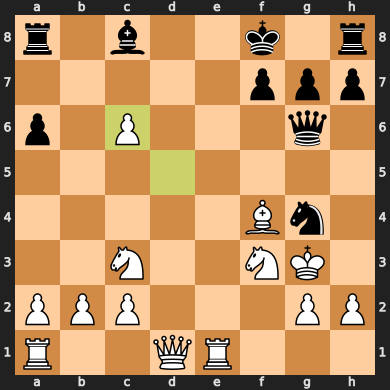

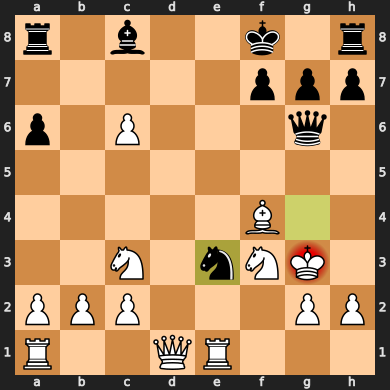

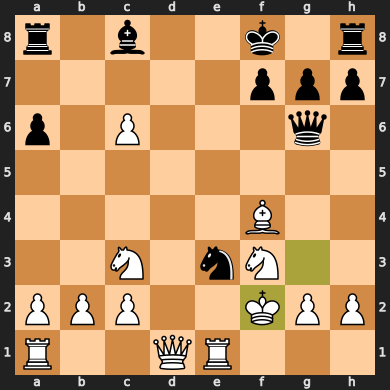

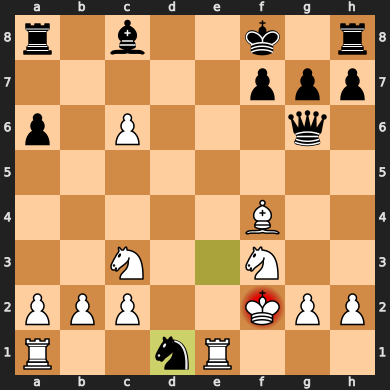

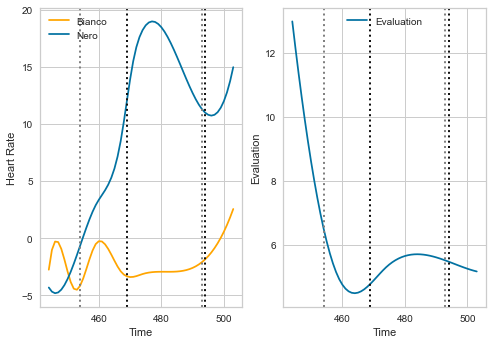

In [103]:
from scipy.interpolate import UnivariateSpline


ind = 24 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+50]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+50]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-10:lista_c[ind]["Time"]+50].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
plt.show()


This position was really complicated, despite the decrease in the evaluation white is still clearly winning, even if down material ([practically with less material points](https://www.chessstrategyonline.com/content/tutorials/basic-chess-concepts-material)).

But still was ahead after losing the queen.
Black knew that white was ahead but thought that if he managed to eat his queen he would be ahead.

He was planning the [discovered attack](https://www.chess.com/terms/discovered-attack-chess#:~:text=Conclusion-,What%20Is%20A%20Discovered%20Attack%20In%20Chess%3F,known%20as%20a%20discovered%20check.) on the queen from a couple moves back when he played Qg6.

White overlooked it completely as he said he was tunnel visioned on another plan, white still thought that he was better even without his queen even if he thought that this would make, of course, every thing more difficult. 

White managed to check mate black a few moves after.

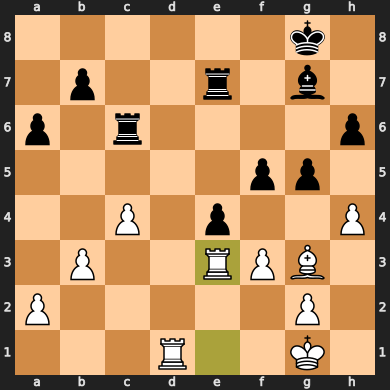

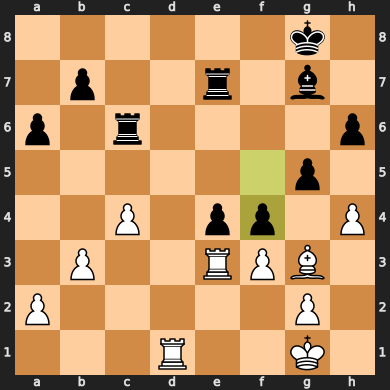

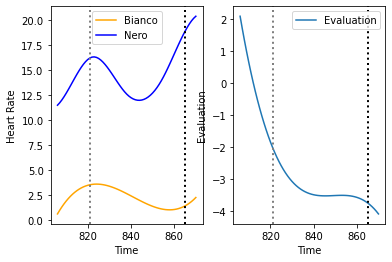

In [49]:
from scipy.interpolate import UnivariateSpline


ind = 21 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-15:lista_c[ind]["Time"]+50]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-15:lista_c[ind]["Time"]+50]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-15:lista_c[ind]["Time"]+50].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)




plt.show()


This sequence is shorter since it's really a really clear [blunder](https://en.wikipedia.org/wiki/Blunder_(chess)) from white, which was immediately punished by black with the move f4 attacking both the bishop and the rook.
White which can't defend both will go on to lose the bishop and later the game.

As in other cases as soon as black exploited an error from white's side it's hr went up, white's didn't change much and decreased slightly from the move

AbsHRBefore                                                         24
AbsHRAfter                                                          24
MoveS                                                              Re7
MovePGN                                                       ['d7e7']
Time                                                               585
DeltaPos                                                        -19.92
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1 ...
Evaluation                                                          20
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1356, dtype: object
6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1 w - - 3 24


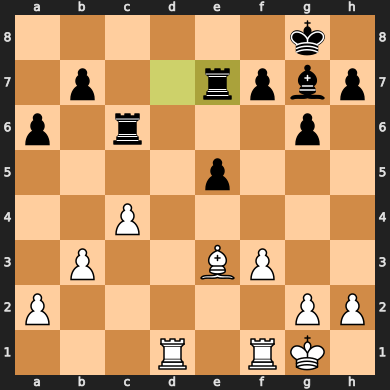

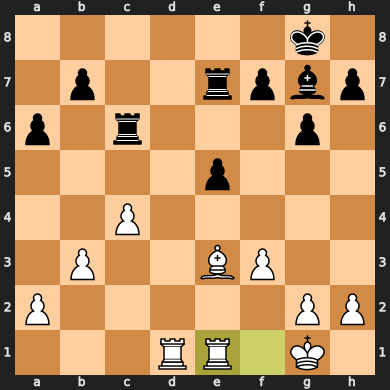

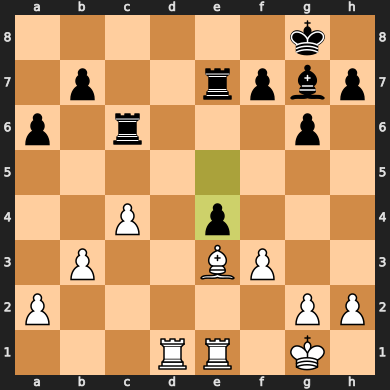

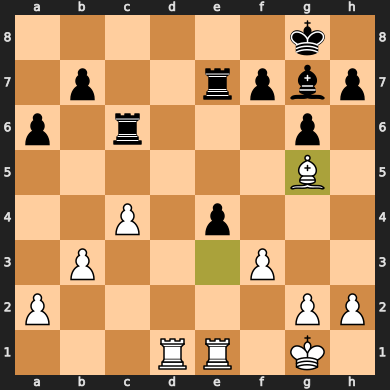

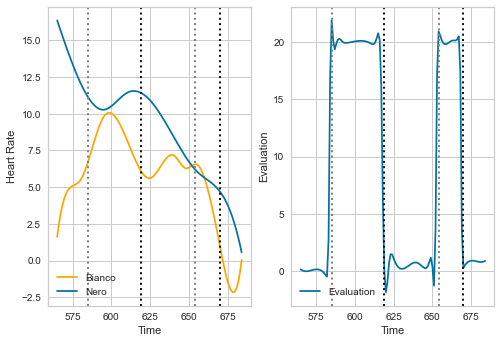

In [254]:
from scipy.interpolate import UnivariateSpline


ind = 17 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 
print(lista_c[ind])

partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100].astype(float)


t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
print(board.fen())
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


This sequence was explained above as a clear explanation on how the players evaluation perspection could change compared to the engine.
Here the engine sees a clear forced checkmate in a few moves but instead the players didn't notice anything.
Their heartrate followed a similar trend.

Game0814-1


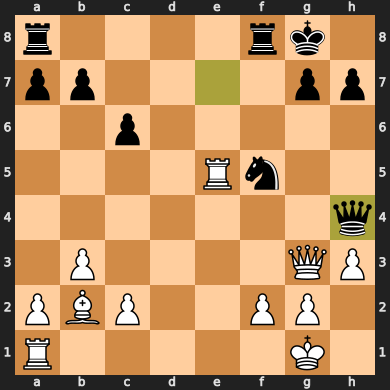

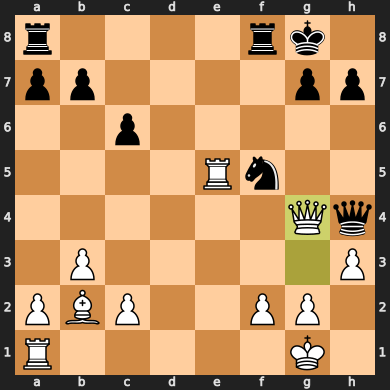

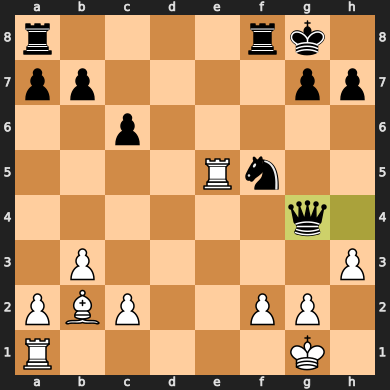

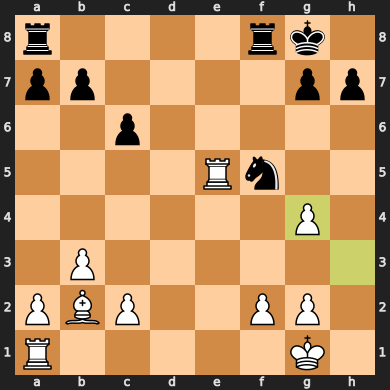

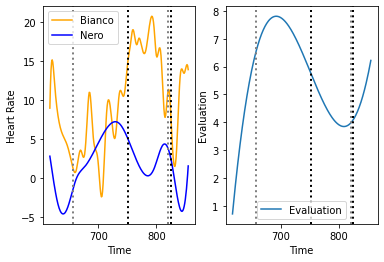

In [51]:
from scipy.interpolate import UnivariateSpline


ind = 12 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]

print(partita)

hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-40:lista_c[ind]["Time"]+200]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-40:lista_c[ind]["Time"]+200]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-40:lista_c[ind]["Time"]+200].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


Here, something simililar happened.

Black made a bad move that could consists in the lost of a piece with correct play.
White said she had a feeling that something was up in this position and that she spend her time looking for the correct move, she unfortunately proceeded to play the non-optimal move. Which still gave a slight advantage but not as much as she could have.

We see that during this long think she had a drastic increase on his heartrate, about a difference of 20 bpm from the time of black's mistake and the time she made her move.






Game0817-3


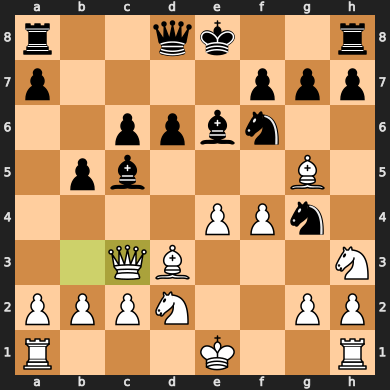

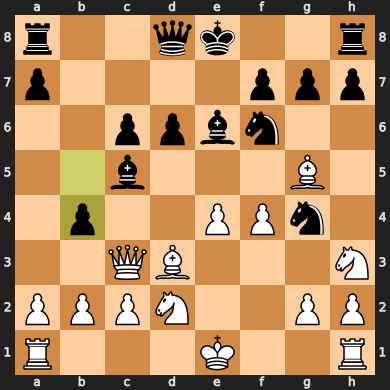

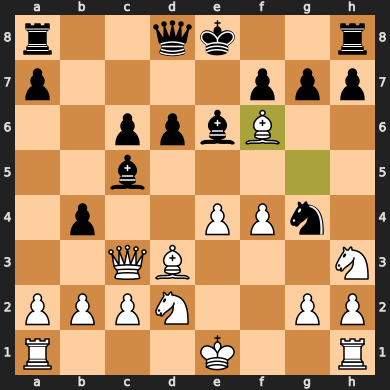

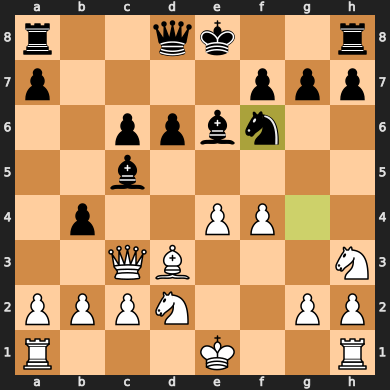

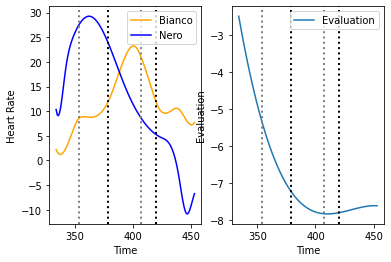

In [50]:
from scipy.interpolate import UnivariateSpline


ind = 10 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]
print(partita)


hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+100].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


This is the second-to-last positiion that we are going to analyse:
Here white simply didn't notice that after the move b4 his queen would be trapped.
As in some previous moves black noticed this from a distnace and was planning to make this move in the near future.

White instead said that he completely missed this idea but he noticed it immediately. Contrary to other times white's heartrate also increased significantly right after the move was played.
As he tried his best to limit the damage.

Losing a queen almost certaintly will lead to losing the game, as losing a queen constitutes a really big disasvantage.
Actually I was playing white in this one and managed to win in the end, as black managed to lose a piece and a queen in a stellar fashion. (For the curious reader: we will omit this for the sake of brevity but you can check it out in png file of the partita_0817-3 folder, after copying and pasting it [here](https://www.chess.com/it/analysis))



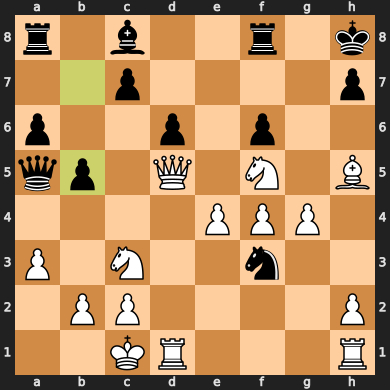

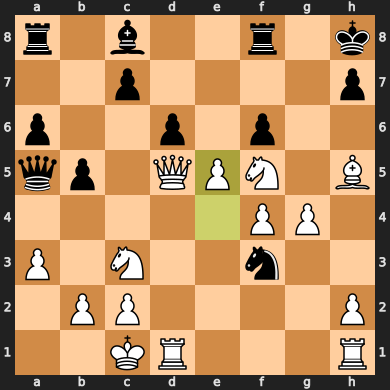

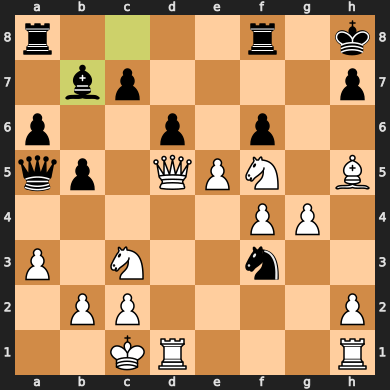

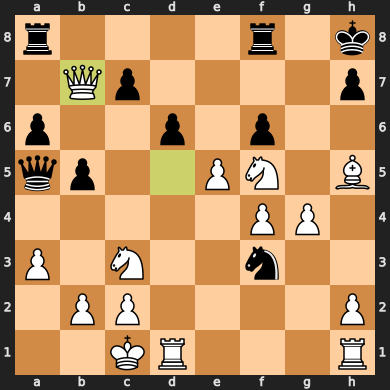

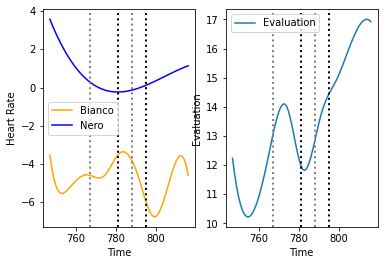

In [52]:
from scipy.interpolate import UnivariateSpline


ind = 8 # select one of the boards above
nm = get_next_move(lista_c[ind].name)
nnm = get_next_move(lista_c[ind].name +1)
pm = get_prev_move(lista_c[ind].name) #load also the next move 


partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+50]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+50]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+50].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))

ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax2.legend(['Evaluation', 'Move', 'NextMove'])


board =chess.Board(pm["Board"])

board.push(chess.Move.from_uci(eval(lista_c[ind]["MovePGN"])[0]))
ax1.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(lista_c[ind]["Time"], color='gray', linestyle='dotted', linewidth=2)
display(board)
next = get_next_move(lista_c[ind].name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='gray', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)
next = get_next_move(next.name)
ax1.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(next["Time"], color='k', linestyle='dotted', linewidth=2)
move = chess.Move.from_uci(eval(next["MovePGN"])[0])
board.push(move)
display(board)

plt.show()


For this last position we actually saved something rather unusual, thus far it's clear that there's something that links some of the moves with the change in heartrate.
As we expected this was really a difficult task to achieve and of course there are a lot of variables that we could not take into account.

Here black made a clear mistake, hanging a rook and giving white the possibility to capture which she didn't take.
Then black went on to cover the rook and hanging his light square bishop instead. White captured this time.

Black heart rate was pretty much unchanged and white's, that was in a negative range had more significant fluctuations, first when black hanged the rook, even if she didn't take it and then her heart rate decreased during the capture of the bishop.


As you probably have noticed heartrate actually changes in a variety of ways and for many different factors ([Draghici AE, Taylor JA. The physiological basis and measurement of heart rate variability in humans. J Physiol Anthropol. 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5039876/))  so isolating the times it happened, or didn't happen because of particular move was a really difficult task. Furthermore we think that this same study would have lead to different results with higher level players playing in a more controlled, long time tournament. A big prize money or the sake of the glory could make a huge difference in the heartrate fluctations and would surely have lead to more interesting results.

Nonetheless we are happy with our analysis thus far.